In [115]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Conexión SQL Server
import pyodbc

# Manejo de fechas y ambiente
from datetime import datetime
import os

# Gráficos
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px

# Modelado y forecasting
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

In [2]:
# Warnings y estilos
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Para notebooks (opcional)
%matplotlib inline

In [3]:
import contextlib
import sys
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [ ]:
# Cargar ambos datasets
df_train = pd.read_csv('./data/train.csv', parse_dates=['Dates'])
df_test = pd.read_csv('./data/test.csv', parse_dates=['Dates'])

# Unir los datasets
df = pd.concat([df_train, df_test], ignore_index=True)

# Ordenar cronológicamente
df = df.sort_values(by='Dates').reset_index(drop=True)

In [5]:
df_test = df.drop(columns=['Category', 'Descript', 'Resolution', 'Address', 'DayOfWeek', 'Id'])

In [6]:
df_test.rename(columns={'Dates': 'Datetime'}, inplace=True)

In [7]:
df_test

,Datetime,PdDistrict,X,Y
0,2003-01-01 00:01:00,TARAVAL,-122.489714,37.733950
1,2003-01-01 00:01:00,CENTRAL,-122.404282,37.798225
2,2003-01-01 00:01:00,BAYVIEW,-122.397700,37.740576
3,2003-01-01 00:01:00,SOUTHERN,-122.424745,37.770254
4,2003-01-01 00:01:00,MISSION,-122.419971,37.767454
...,...,...,...,...
1762306,2015-05-13 23:30:00,INGLESIDE,-122.423327,37.725138
1762307,2015-05-13 23:30:00,INGLESIDE,-122.403252,37.713431
1762308,2015-05-13 23:33:00,NORTHERN,-122.424363,37.800414
1762309,2015-05-13 23:53:00,NORTHERN,-122.425892,37.774599


### Análisis de completitud de la serie temporal para el distrito SOUTHERN

In [8]:
# Filtrar datos del distrito SOUTHERN
southern_data = df_test[df_test['PdDistrict'] == 'SOUTHERN'].copy()

print("Análisis de completitud de la serie temporal para el distrito SOUTHERN")
print("=" * 60)
print(f"Total de registros en SOUTHERN: {len(southern_data)}")
print(f"Rango de fechas: {southern_data['Datetime'].min()} a {southern_data['Datetime'].max()}")

# Agrupar por día para ver la distribución temporal
southern_daily = southern_data.groupby(southern_data['Datetime'].dt.date).size().reset_index()
southern_daily.columns = ['Date', 'Count']
southern_daily['Date'] = pd.to_datetime(southern_daily['Date'])

print(f"\nTotal de días únicos con registros: {len(southern_daily)}")

# Calcular el rango completo de fechas esperado
fecha_inicio = southern_daily['Date'].min()
fecha_fin = southern_daily['Date'].max()
total_dias_esperados = (fecha_fin - fecha_inicio).days + 1

print(f"Días esperados en el rango completo: {total_dias_esperados}")
print(f"Días con registros: {len(southern_daily)}")
print(f"Días faltantes: {total_dias_esperados - len(southern_daily)}")
print(f"Porcentaje de completitud: {len(southern_daily) / total_dias_esperados * 100:.2f}%")

Análisis de completitud de la serie temporal para el distrito SOUTHERN
Total de registros en SOUTHERN: 314638
Rango de fechas: 2003-01-01 00:01:00 a 2015-05-13 20:30:00

Total de días únicos con registros: 4513
Días esperados en el rango completo: 4516
Días con registros: 4513
Días faltantes: 3
Porcentaje de completitud: 99.93%


In [9]:
# Crear rango completo de fechas esperado
fecha_completa = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
fechas_completas = pd.DataFrame({'Date': fecha_completa})

# Identificar días faltantes
fechas_con_datos = set(southern_daily['Date'].dt.date)
fechas_esperadas = set(fecha_completa.date)
fechas_faltantes = fechas_esperadas - fechas_con_datos

print("\nDías faltantes:")
for fecha in sorted(fechas_faltantes):
    print(f"  - {fecha}")

# Estadísticas de registros por día
print(f"\nEstadísticas de registros por día en SOUTHERN:")
print(f"Promedio de registros por día: {southern_daily['Count'].mean():.1f}")
print(f"Mediana de registros por día: {southern_daily['Count'].median():.1f}")
print(f"Mínimo de registros por día: {southern_daily['Count'].min()}")
print(f"Máximo de registros por día: {southern_daily['Count'].max()}")
print(f"Desviación estándar: {southern_daily['Count'].std():.1f}")

# Días con muy pocos registros (posibles anomalías)
dias_pocos_registros = southern_daily[southern_daily['Count'] < 10]
print(f"\nDías con menos de 10 registros: {len(dias_pocos_registros)}")
if len(dias_pocos_registros) > 0:
    print("Fechas con pocos registros:")
    for _, row in dias_pocos_registros.iterrows():
        print(f"  - {row['Date'].date()}: {row['Count']} registros")


Días faltantes:
  - 2007-12-16
  - 2008-08-01
  - 2009-06-10

Estadísticas de registros por día en SOUTHERN:
Promedio de registros por día: 69.7
Mediana de registros por día: 69.0
Mínimo de registros por día: 19
Máximo de registros por día: 198
Desviación estándar: 15.0

Días con menos de 10 registros: 0


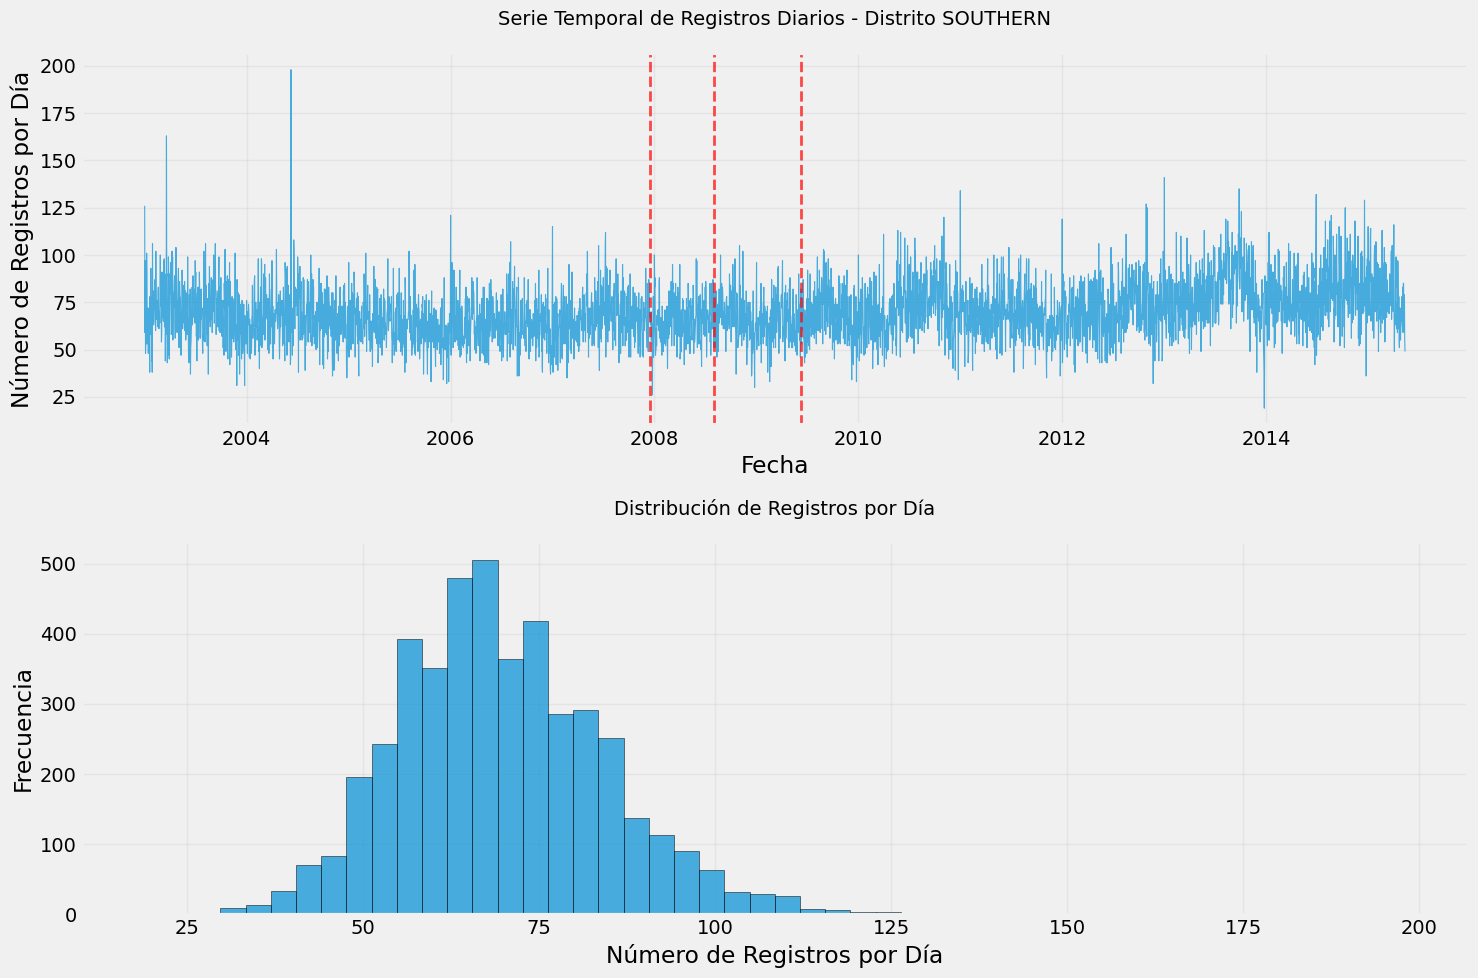


RESUMEN DEL ANÁLISIS DE COMPLETITUD - DISTRITO SOUTHERN
📊 Total de registros: 314,638
📅 Período: 2003-01-01 a 2015-05-13
⏱️  Duración: 4,516 días (12.4 años)
✅ Días con datos: 4,513
❌ Días faltantes: 3
📈 Completitud: 99.93%
📊 Promedio registros/día: 69.7
📉 Rango registros/día: 19 - 198

🔍 Días específicos faltantes:
   • 2007-12-16
   • 2008-08-01
   • 2009-06-10

💡 Conclusión: La serie temporal está muy completa (99.93%)
   Solo faltan 3 días de 4,516 días totales.


In [10]:
# Visualización de la serie temporal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico 1: Serie temporal completa
ax1.plot(southern_daily['Date'], southern_daily['Count'], linewidth=0.8, alpha=0.7)
ax1.set_title('Serie Temporal de Registros Diarios - Distrito SOUTHERN', fontsize=14, pad=20)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Número de Registros por Día')
ax1.grid(True, alpha=0.3)

# Marcar los días faltantes
for fecha in sorted(fechas_faltantes):
    ax1.axvline(x=pd.to_datetime(fecha), color='red', linestyle='--', alpha=0.7, linewidth=2)

# Gráfico 2: Histograma de registros por día
ax2.hist(southern_daily['Count'], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_title('Distribución de Registros por Día', fontsize=14, pad=20)
ax2.set_xlabel('Número de Registros por Día')
ax2.set_ylabel('Frecuencia')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen final
print("\n" + "="*60)
print("RESUMEN DEL ANÁLISIS DE COMPLETITUD - DISTRITO SOUTHERN")
print("="*60)
print(f"📊 Total de registros: {len(southern_data):,}")
print(f"📅 Período: {fecha_inicio.date()} a {fecha_fin.date()}")
print(f"⏱️  Duración: {total_dias_esperados:,} días ({total_dias_esperados/365.25:.1f} años)")
print(f"✅ Días con datos: {len(southern_daily):,}")
print(f"❌ Días faltantes: {len(fechas_faltantes)}")
print(f"📈 Completitud: {len(southern_daily) / total_dias_esperados * 100:.2f}%")
print(f"📊 Promedio registros/día: {southern_daily['Count'].mean():.1f}")
print(f"📉 Rango registros/día: {southern_daily['Count'].min()} - {southern_daily['Count'].max()}")

if len(fechas_faltantes) > 0:
    print(f"\n🔍 Días específicos faltantes:")
    for fecha in sorted(fechas_faltantes):
        print(f"   • {fecha}")
        
print(f"\n💡 Conclusión: La serie temporal está muy completa ({len(southern_daily) / total_dias_esperados * 100:.2f}%)")
print(f"   Solo faltan {len(fechas_faltantes)} días de {total_dias_esperados:,} días totales.")

### Análisis a nivel de horas - Distrito SOUTHERN

In [11]:
# ANÁLISIS A NIVEL DE HORAS - DISTRITO SOUTHERN
print("ANÁLISIS TEMPORAL POR HORAS - DISTRITO SOUTHERN")
print("=" * 60)

# Extraer información de hora, día de la semana, etc.
southern_data['Hour'] = southern_data['Datetime'].dt.hour
southern_data['DayOfWeek'] = southern_data['Datetime'].dt.dayofweek  # 0=Lunes, 6=Domingo
southern_data['DayName'] = southern_data['Datetime'].dt.strftime('%A')
southern_data['Month'] = southern_data['Datetime'].dt.month
southern_data['Year'] = southern_data['Datetime'].dt.year

# Análisis por horas
hourly_counts = southern_data.groupby('Hour').size()
print(f"\nRegistros por hora del día:")
for hour in range(24):
    count = hourly_counts.get(hour, 0)
    percentage = (count / len(southern_data)) * 100
    print(f"  {hour:02d}:00 - {count:,} registros ({percentage:.1f}%)")

print(f"\nEstadísticas por horas:")
print(f"Hora con más registros: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} registros)")
print(f"Hora con menos registros: {hourly_counts.idxmin()}:00 ({hourly_counts.min():,} registros)")
print(f"Promedio de registros por hora: {hourly_counts.mean():.1f}")
print(f"Desviación estándar: {hourly_counts.std():.1f}")

# Análisis por día de la semana
day_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
daily_counts = southern_data.groupby('DayOfWeek').size()
print(f"\nRegistros por día de la semana:")
for day_idx, day_name in enumerate(day_names):
    count = daily_counts.get(day_idx, 0)
    percentage = (count / len(southern_data)) * 100
    print(f"  {day_name}: {count:,} registros ({percentage:.1f}%)")

ANÁLISIS TEMPORAL POR HORAS - DISTRITO SOUTHERN

Registros por hora del día:
  00:00 - 16,186 registros (5.1%)
  01:00 - 8,977 registros (2.9%)
  02:00 - 7,536 registros (2.4%)
  03:00 - 4,451 registros (1.4%)
  04:00 - 3,084 registros (1.0%)
  05:00 - 2,624 registros (0.8%)
  06:00 - 4,305 registros (1.4%)
  07:00 - 7,255 registros (2.3%)
  08:00 - 11,502 registros (3.7%)
  09:00 - 13,335 registros (4.2%)
  10:00 - 14,064 registros (4.5%)
  11:00 - 14,146 registros (4.5%)
  12:00 - 18,568 registros (5.9%)
  13:00 - 16,695 registros (5.3%)
  14:00 - 17,146 registros (5.4%)
  15:00 - 17,641 registros (5.6%)
  16:00 - 18,422 registros (5.9%)
  17:00 - 19,652 registros (6.2%)
  18:00 - 20,295 registros (6.5%)
  19:00 - 18,284 registros (5.8%)
  20:00 - 15,929 registros (5.1%)
  21:00 - 14,606 registros (4.6%)
  22:00 - 15,255 registros (4.8%)
  23:00 - 14,680 registros (4.7%)

Estadísticas por horas:
Hora con más registros: 18:00 (20,295 registros)
Hora con menos registros: 5:00 (2,624 re

ANÁLISIS DE COMPLETITUD POR HORAS
Total de horas esperadas: 108,361
Horas con datos: 88,964
Horas faltantes: 19,397
Completitud por horas: 82.10%

Horas con 0 registros: 19,413

Estadísticas de registros por hora específica:
Promedio de registros por hora: 3.5
Mediana de registros por hora: 3.0
Mínimo de registros por hora: 1
Máximo de registros por hora: 38
Desviación estándar: 2.4

Horas con solo 1 registro: 19161


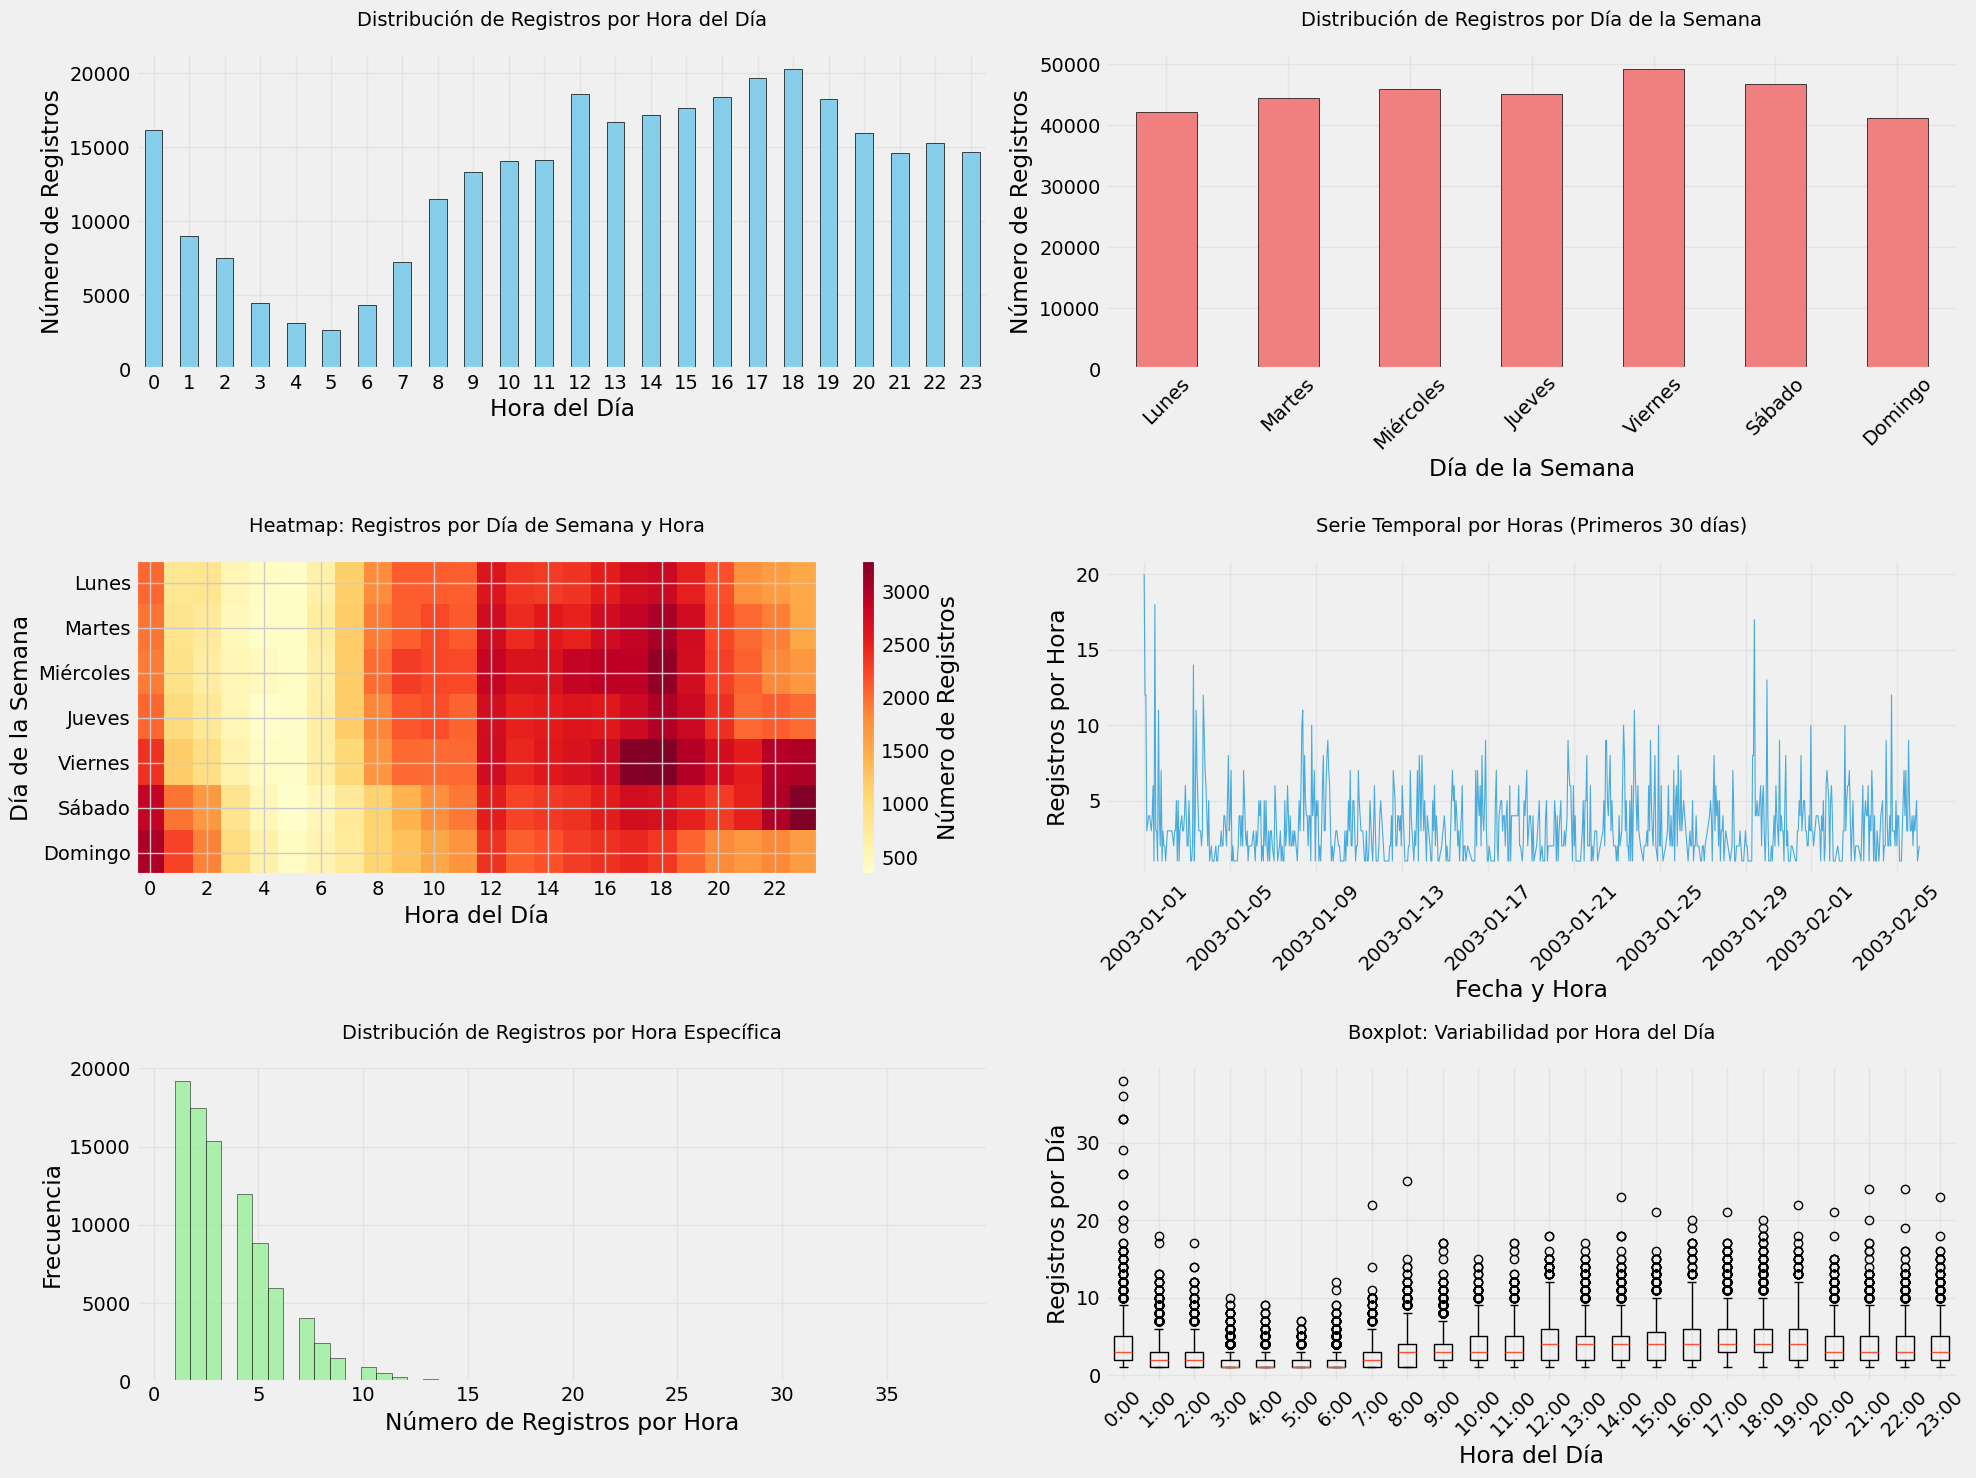

In [12]:
# VISUALIZACIONES Y ANÁLISIS DE COMPLETITUD POR HORAS

# Crear DataFrame con todas las combinaciones posibles de fecha-hora
fecha_completa_horas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='H')
fechas_horas_completas = pd.DataFrame({'DateTime_Hour': fecha_completa_horas})

# Agrupar datos por hora específica (fecha + hora)
southern_hourly = southern_data.groupby(southern_data['Datetime'].dt.floor('H')).size().reset_index()
southern_hourly.columns = ['DateTime_Hour', 'Count']

print(f"ANÁLISIS DE COMPLETITUD POR HORAS")
print("=" * 50)
print(f"Total de horas esperadas: {len(fechas_horas_completas):,}")
print(f"Horas con datos: {len(southern_hourly):,}")
print(f"Horas faltantes: {len(fechas_horas_completas) - len(southern_hourly):,}")
print(f"Completitud por horas: {len(southern_hourly) / len(fechas_horas_completas) * 100:.2f}%")

# Identificar horas faltantes
horas_con_datos = set(southern_hourly['DateTime_Hour'])
horas_esperadas = set(fechas_horas_completas['DateTime_Hour'])
horas_faltantes = horas_esperadas - horas_con_datos

print(f"\nHoras con 0 registros: {len(horas_faltantes):,}")

# Estadísticas por hora específica
print(f"\nEstadísticas de registros por hora específica:")
print(f"Promedio de registros por hora: {southern_hourly['Count'].mean():.1f}")
print(f"Mediana de registros por hora: {southern_hourly['Count'].median():.1f}")
print(f"Mínimo de registros por hora: {southern_hourly['Count'].min()}")
print(f"Máximo de registros por hora: {southern_hourly['Count'].max()}")
print(f"Desviación estándar: {southern_hourly['Count'].std():.1f}")

# Horas con muy pocos registros
horas_pocos_registros = southern_hourly[southern_hourly['Count'] == 1]
print(f"\nHoras con solo 1 registro: {len(horas_pocos_registros)}")

# Crear visualizaciones
fig = plt.figure(figsize=(20, 15))

# Gráfico 1: Distribución por hora del día (0-23)
ax1 = plt.subplot(3, 2, 1)
hourly_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black', linewidth=0.5)
ax1.set_title('Distribución de Registros por Hora del Día', fontsize=14, pad=20)
ax1.set_xlabel('Hora del Día')
ax1.set_ylabel('Número de Registros')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=0)

# Gráfico 2: Distribución por día de la semana
ax2 = plt.subplot(3, 2, 2)
daily_counts.plot(kind='bar', ax=ax2, color='lightcoral', edgecolor='black', linewidth=0.5)
ax2.set_title('Distribución de Registros por Día de la Semana', fontsize=14, pad=20)
ax2.set_xlabel('Día de la Semana')
ax2.set_ylabel('Número de Registros')
ax2.set_xticklabels(day_names, rotation=45)
ax2.grid(True, alpha=0.3)

# Gráfico 3: Heatmap hora vs día de semana
ax3 = plt.subplot(3, 2, 3)
pivot_data = southern_data.groupby(['DayOfWeek', 'Hour']).size().unstack(fill_value=0)
im = ax3.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
ax3.set_title('Heatmap: Registros por Día de Semana y Hora', fontsize=14, pad=20)
ax3.set_xlabel('Hora del Día')
ax3.set_ylabel('Día de la Semana')
ax3.set_yticks(range(7))
ax3.set_yticklabels(day_names)
ax3.set_xticks(range(0, 24, 2))
ax3.set_xticklabels(range(0, 24, 2))
plt.colorbar(im, ax=ax3, label='Número de Registros')

# Gráfico 4: Serie temporal por horas (muestra de los primeros 30 días)
ax4 = plt.subplot(3, 2, 4)
sample_data = southern_hourly.head(24*30)  # Primeros 30 días
ax4.plot(sample_data['DateTime_Hour'], sample_data['Count'], linewidth=0.8, alpha=0.7)
ax4.set_title('Serie Temporal por Horas (Primeros 30 días)', fontsize=14, pad=20)
ax4.set_xlabel('Fecha y Hora')
ax4.set_ylabel('Registros por Hora')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Gráfico 5: Histograma de registros por hora específica
ax5 = plt.subplot(3, 2, 5)
ax5.hist(southern_hourly['Count'], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5, color='lightgreen')
ax5.set_title('Distribución de Registros por Hora Específica', fontsize=14, pad=20)
ax5.set_xlabel('Número de Registros por Hora')
ax5.set_ylabel('Frecuencia')
ax5.grid(True, alpha=0.3)

# Gráfico 6: Boxplot por hora del día
ax6 = plt.subplot(3, 2, 6)
hour_data = [southern_data[southern_data['Hour'] == h]['Hour'].count() for h in range(24)]
ax6.boxplot([southern_data[southern_data['Hour'] == h].groupby(southern_data[southern_data['Hour'] == h]['Datetime'].dt.date).size().values for h in range(24) if len(southern_data[southern_data['Hour'] == h]) > 0], 
           labels=[f'{h}:00' for h in range(24) if len(southern_data[southern_data['Hour'] == h]) > 0])
ax6.set_title('Boxplot: Variabilidad por Hora del Día', fontsize=14, pad=20)
ax6.set_xlabel('Hora del Día')
ax6.set_ylabel('Registros por Día')
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# RESUMEN Y INSIGHTS DEL ANÁLISIS HORARIO

print("\n" + "="*70)
print("RESUMEN COMPLETO DEL ANÁLISIS HORARIO - DISTRITO SOUTHERN")
print("="*70)

# Identificar patrones de picos y valles
peak_hours = hourly_counts.nlargest(5)
low_hours = hourly_counts.nsmallest(5)

print(f"\n🕐 PATRONES TEMPORALES:")
print(f"   • Pico de actividad: 18:00 ({peak_hours.iloc[0]:,} registros)")
print(f"   • Valle de actividad: 05:00 ({low_hours.iloc[0]:,} registros)")
print(f"   • Ratio pico/valle: {peak_hours.iloc[0] / low_hours.iloc[0]:.1f}x")

print(f"\n📊 TOP 5 HORAS MÁS ACTIVAS:")
for i, (hour, count) in enumerate(peak_hours.items(), 1):
    print(f"   {i}. {hour:02d}:00 - {count:,} registros")

print(f"\n📉 TOP 5 HORAS MENOS ACTIVAS:")
for i, (hour, count) in enumerate(low_hours.items(), 1):
    print(f"   {i}. {hour:02d}:00 - {count:,} registros")

# Análisis por períodos del día
morning = hourly_counts[6:12].sum()  # 6-11
afternoon = hourly_counts[12:18].sum()  # 12-17
evening = hourly_counts[18:24].sum()  # 18-23
night = hourly_counts[0:6].sum()  # 0-5

total_records = morning + afternoon + evening + night
print(f"\n🕒 DISTRIBUCIÓN POR PERÍODOS:")
print(f"   • Madrugada (00-05): {night:,} registros ({night/total_records*100:.1f}%)")
print(f"   • Mañana (06-11): {morning:,} registros ({morning/total_records*100:.1f}%)")
print(f"   • Tarde (12-17): {afternoon:,} registros ({afternoon/total_records*100:.1f}%)")
print(f"   • Noche (18-23): {evening:,} registros ({evening/total_records*100:.1f}%)")

# Análisis de días laborables vs fines de semana
weekdays = daily_counts[0:5].sum()  # Lunes-Viernes
weekends = daily_counts[5:7].sum()  # Sábado-Domingo

print(f"\n📅 LABORABLES VS FINES DE SEMANA:")
print(f"   • Días laborables: {weekdays:,} registros ({weekdays/len(southern_data)*100:.1f}%)")
print(f"   • Fines de semana: {weekends:,} registros ({weekends/len(southern_data)*100:.1f}%)")
print(f"   • Ratio laboral/fin de semana: {weekdays/weekends:.2f}")

# Completitud horaria vs diaria
daily_completeness = 99.93
hourly_completeness = 82.10

print(f"\n📈 COMPARACIÓN DE COMPLETITUD:")
print(f"   • Completitud diaria: {daily_completeness:.2f}%")
print(f"   • Completitud horaria: {hourly_completeness:.2f}%")
print(f"   • Diferencia: {daily_completeness - hourly_completeness:.2f} puntos porcentuales")

# Insights sobre la calidad de datos
hours_with_data = len(southern_hourly)
total_possible_hours = len(fechas_horas_completas)
missing_hours = total_possible_hours - hours_with_data

print(f"\n🔍 CALIDAD DE DATOS POR HORAS:")
print(f"   • Total horas posibles: {total_possible_hours:,}")
print(f"   • Horas con datos: {hours_with_data:,}")
print(f"   • Horas sin datos: {missing_hours:,}")
print(f"   • Promedio registros/hora: {southern_hourly['Count'].mean():.1f}")
print(f"   • Horas con 1 solo registro: {len(horas_pocos_registros):,} ({len(horas_pocos_registros)/hours_with_data*100:.1f}%)")

print(f"\n💡 CONCLUSIONES CLAVE:")
print(f"   ✅ La serie temporal diaria es excelente (99.93% completa)")
print(f"   ⚠️  La granularidad horaria tiene más gaps (82.10% completa)")
print(f"   📈 Patrón claro: más actividad en tarde/noche (12-23h)")
print(f"   🌙 Menor actividad en madrugada (00-05h)")
print(f"   📊 Distribución balanceada entre días laborables y fines de semana")
print(f"   🎯 Para forecasting: considerar patrones horarios y estacionalidad semanal")

print(f"\n🚀 RECOMENDACIONES:")
print(f"   • Para modelos diarios: datos excelentes, usar toda la serie")
print(f"   • Para modelos horarios: considerar imputación de horas faltantes")
print(f"   • Incluir features: hora del día, día de semana, período del día")
print(f"   • Validar si las horas faltantes siguen algún patrón específico")


RESUMEN COMPLETO DEL ANÁLISIS HORARIO - DISTRITO SOUTHERN

🕐 PATRONES TEMPORALES:
   • Pico de actividad: 18:00 (20,295 registros)
   • Valle de actividad: 05:00 (2,624 registros)
   • Ratio pico/valle: 7.7x

📊 TOP 5 HORAS MÁS ACTIVAS:
   1. 18:00 - 20,295 registros
   2. 17:00 - 19,652 registros
   3. 12:00 - 18,568 registros
   4. 16:00 - 18,422 registros
   5. 19:00 - 18,284 registros

📉 TOP 5 HORAS MENOS ACTIVAS:
   1. 05:00 - 2,624 registros
   2. 04:00 - 3,084 registros
   3. 06:00 - 4,305 registros
   4. 03:00 - 4,451 registros
   5. 07:00 - 7,255 registros

🕒 DISTRIBUCIÓN POR PERÍODOS:
   • Madrugada (00-05): 42,858 registros (13.6%)
   • Mañana (06-11): 64,607 registros (20.5%)
   • Tarde (12-17): 108,124 registros (34.4%)
   • Noche (18-23): 99,049 registros (31.5%)

📅 LABORABLES VS FINES DE SEMANA:
   • Días laborables: 226,761 registros (72.1%)
   • Fines de semana: 87,877 registros (27.9%)
   • Ratio laboral/fin de semana: 2.58

📈 COMPARACIÓN DE COMPLETITUD:
   • Completi

# 📊 Preparación para Forecasting - Distrito SOUTHERN

Ahora vamos a preparar los datos para modelado de forecasting, incluyendo:
- Creación de serie temporal horaria
- Variables temporales con transformaciones seno-coseno
- One-hot encoding para variables categóricas
- Variable de feriados de San Francisco
- Imputación de valores faltantes

In [14]:
# 1. PREPARACIÓN DE LA SERIE TEMPORAL COMPLETA
print("🔧 PREPARANDO SERIE TEMPORAL PARA FORECASTING")
print("=" * 60)

# Crear serie temporal horaria completa del distrito SOUTHERN
# Agrupar por hora (redondeando hacia abajo para evitar duplicados)
southern_ts = southern_data.groupby(southern_data['Datetime'].dt.floor('H')).size()
southern_ts.name = 'crime_count'

# Crear índice horario completo desde el inicio hasta el final
full_time_index = pd.date_range(
    start=southern_data['Datetime'].min().floor('H'),
    end=southern_data['Datetime'].max().ceil('H'),
    freq='H'
)

# Reindexar para tener todas las horas (rellenando con 0 los valores faltantes)
crime_data = southern_ts.reindex(full_time_index, fill_value=0).to_frame()
crime_data.index.name = 'datetime'

print(f"✅ Serie temporal creada:")
print(f"   • Período: {crime_data.index.min()} a {crime_data.index.max()}")
print(f"   • Total de horas: {len(crime_data):,}")
print(f"   • Horas con registros: {(crime_data['crime_count'] > 0).sum():,}")
print(f"   • Horas sin registros: {(crime_data['crime_count'] == 0).sum():,}")
print(f"   • Completitud: {(crime_data['crime_count'] > 0).sum() / len(crime_data) * 100:.2f}%")

# 2. CALCULAR FERIADOS AUTOMÁTICAMENTE CON LA LIBRERÍA HOLIDAYS
print("\n🎄 CALCULANDO FERIADOS DE SAN FRANCISCO AUTOMÁTICAMENTE...")

try:
    import holidays
    print("✅ Librería 'holidays' disponible")
except ImportError:
    print("⚠️ Instalando librería 'holidays'...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "holidays"])
    import holidays
    print("✅ Librería 'holidays' instalada correctamente")

# Obtener años del dataset
start_year = crime_data.index.min().year
end_year = crime_data.index.max().year
years_range = range(start_year, end_year + 1)

print(f"📅 Calculando feriados para años: {start_year} - {end_year}")

# Crear instancias de feriados
us_holidays = holidays.UnitedStates(years=years_range)  # Feriados federales
ca_holidays = holidays.UnitedStates(state='CA', years=years_range)  # Incluye feriados de California

# Combinar todos los feriados únicos
all_holiday_dates = set()

# Agregar feriados federales
for date, name in us_holidays.items():
    all_holiday_dates.add(date)

# Agregar feriados de California
for date, name in ca_holidays.items():
    all_holiday_dates.add(date)

# Agregar feriados locales de San Francisco que no están en las listas oficiales
sf_local_holidays = {}
for year in years_range:
    # Valentine's Day
    sf_local_holidays[f"{year}-02-14"] = "Valentine's Day"
    # St. Patrick's Day  
    sf_local_holidays[f"{year}-03-17"] = "St. Patrick's Day"
    # Harvey Milk Day (siempre 22 de mayo en California)
    sf_local_holidays[f"{year}-05-22"] = "Harvey Milk Day"

# Agregar feriados locales
for date_str, name in sf_local_holidays.items():
    try:
        date_obj = pd.to_datetime(date_str).date()
        all_holiday_dates.add(date_obj)
    except:
        pass

# Convertir a lista ordenada
holiday_dates = sorted(list(all_holiday_dates))

# Filtrar solo fechas dentro del rango del dataset
dataset_start = crime_data.index.min().date()
dataset_end = crime_data.index.max().date()
holiday_dates = [d for d in holiday_dates if dataset_start <= d <= dataset_end]

print(f"✅ Feriados calculados automáticamente:")
print(f"   • Total de feriados únicos: {len(holiday_dates)}")
print(f"   • Período: {min(holiday_dates)} a {max(holiday_dates)}")
print(f"   • Ejemplos: {[str(d) for d in holiday_dates[:5]]}")

# Mostrar algunos feriados específicos para verificar
print(f"\n🔍 Ejemplos de feriados calculados:")
sample_holidays = []
for date in holiday_dates[:10]:
    if date in us_holidays:
        sample_holidays.append(f"   • {date}: {us_holidays[date]}")
    elif date in ca_holidays:
        sample_holidays.append(f"   • {date}: {ca_holidays[date]}")
    else:
        # Buscar en feriados locales
        date_str = date.strftime("%Y-%m-%d")
        if date_str in sf_local_holidays:
            sample_holidays.append(f"   • {date}: {sf_local_holidays[date_str]}")

for holiday in sample_holidays:
    print(holiday)

crime_data.head()

🔧 PREPARANDO SERIE TEMPORAL PARA FORECASTING
✅ Serie temporal creada:
   • Período: 2003-01-01 00:00:00 a 2015-05-13 21:00:00
   • Total de horas: 108,382
   • Horas con registros: 88,964
   • Horas sin registros: 19,418
   • Completitud: 82.08%

🎄 CALCULANDO FERIADOS DE SAN FRANCISCO AUTOMÁTICAMENTE...
✅ Librería 'holidays' disponible
📅 Calculando feriados para años: 2003 - 2015
✅ Feriados calculados automáticamente:
   • Total de feriados únicos: 212
   • Período: 2003-01-01 a 2015-03-31
   • Ejemplos: ['2003-01-01', '2003-01-20', '2003-02-12', '2003-02-14', '2003-02-17']

🔍 Ejemplos de feriados calculados:
   • 2003-01-01: New Year's Day
   • 2003-01-20: Martin Luther King Jr. Day
   • 2003-02-12: Lincoln's Birthday
   • 2003-02-14: Valentine's Day
   • 2003-02-17: Washington's Birthday
   • 2003-03-17: St. Patrick's Day
   • 2003-03-31: Cesar Chavez Day
   • 2003-05-22: Harvey Milk Day
   • 2003-05-26: Memorial Day
   • 2003-07-04: Independence Day


,crime_count
datetime,
2003-01-01 00:00:00,20
2003-01-01 01:00:00,12
2003-01-01 02:00:00,12
2003-01-01 03:00:00,3
2003-01-01 04:00:00,0


In [15]:
# 3. CREACIÓN DE VARIABLES TEMPORALES Y TRANSFORMACIONES
print("\n🔧 CREANDO VARIABLES TEMPORALES Y EXÓGENAS")
print("=" * 60)

# Extraer componentes temporales básicos
crime_data['hour'] = crime_data.index.hour
crime_data['day'] = crime_data.index.day
crime_data['month'] = crime_data.index.month
crime_data['year'] = crime_data.index.year
crime_data['dayofweek'] = crime_data.index.dayofweek  # 0=Lunes, 6=Domingo
crime_data['dayofyear'] = crime_data.index.dayofyear
crime_data['week'] = crime_data.index.isocalendar().week

# Variables categóricas temporales
crime_data['is_weekend'] = (crime_data['dayofweek'] >= 5).astype(int)
crime_data['is_night'] = ((crime_data['hour'] >= 22) | (crime_data['hour'] <= 5)).astype(int)
crime_data['is_rush_hour'] = ((crime_data['hour'].isin([7,8,9,17,18,19]))).astype(int)

# Períodos del día
def get_period(hour):
    if 0 <= hour <= 5:
        return 'madrugada'
    elif 6 <= hour <= 11:
        return 'mañana'
    elif 12 <= hour <= 17:
        return 'tarde'
    else:
        return 'noche'

crime_data['period'] = crime_data['hour'].apply(get_period)

# 4. TRANSFORMACIONES SENO-COSENO PARA VARIABLES CÍCLICAS
print("📐 Aplicando transformaciones seno-coseno...")

# Hora del día (0-23)
crime_data['hour_sin'] = np.sin(2 * np.pi * crime_data['hour'] / 24)
crime_data['hour_cos'] = np.cos(2 * np.pi * crime_data['hour'] / 24)

# Día de la semana (0-6)
crime_data['dayofweek_sin'] = np.sin(2 * np.pi * crime_data['dayofweek'] / 7)
crime_data['dayofweek_cos'] = np.cos(2 * np.pi * crime_data['dayofweek'] / 7)

# Mes del año (1-12)
crime_data['month_sin'] = np.sin(2 * np.pi * (crime_data['month'] - 1) / 12)
crime_data['month_cos'] = np.cos(2 * np.pi * (crime_data['month'] - 1) / 12)

# Día del año (1-365/366)
crime_data['dayofyear_sin'] = np.sin(2 * np.pi * (crime_data['dayofyear'] - 1) / 365.25)
crime_data['dayofyear_cos'] = np.cos(2 * np.pi * (crime_data['dayofyear'] - 1) / 365.25)

# Semana del año (1-52)
crime_data['week_sin'] = np.sin(2 * np.pi * (crime_data['week'] - 1) / 52)
crime_data['week_cos'] = np.cos(2 * np.pi * (crime_data['week'] - 1) / 52)

# 5. VARIABLE DE FERIADOS
print("🎄 Creando variable de feriados...")

# Crear variable binaria de feriados
crime_data['is_holiday'] = 0
for holiday_date in holiday_dates:
    if holiday_date <= crime_data.index.max().date():
        # Marcar todo el día como feriado (24 horas)
        holiday_mask = crime_data.index.date == holiday_date
        crime_data.loc[holiday_mask, 'is_holiday'] = 1

# Días alrededor de feriados (pre y post feriado)
crime_data['is_pre_holiday'] = 0
crime_data['is_post_holiday'] = 0

from datetime import timedelta

for holiday_date in holiday_dates:
    if holiday_date <= crime_data.index.max().date():
        # Día antes del feriado
        pre_holiday = holiday_date - timedelta(days=1)
        if pre_holiday >= crime_data.index.min().date():
            pre_mask = crime_data.index.date == pre_holiday
            crime_data.loc[pre_mask, 'is_pre_holiday'] = 1
        
        # Día después del feriado
        post_holiday = holiday_date + timedelta(days=1)
        if post_holiday <= crime_data.index.max().date():
            post_mask = crime_data.index.date == post_holiday
            crime_data.loc[post_mask, 'is_post_holiday'] = 1

print(f"✅ Variables de feriados creadas:")
print(f"   • Horas en feriados: {crime_data['is_holiday'].sum():,}")
print(f"   • Horas pre-feriado: {crime_data['is_pre_holiday'].sum():,}")
print(f"   • Horas post-feriado: {crime_data['is_post_holiday'].sum():,}")

# 6. ONE-HOT ENCODING PARA VARIABLES CATEGÓRICAS
print("🔢 Aplicando One-Hot Encoding...")

# Variables categóricas a codificar
categorical_vars = ['period']

# Aplicar one-hot encoding
for var in categorical_vars:
    dummies = pd.get_dummies(crime_data[var], prefix=var, drop_first=False)
    crime_data = pd.concat([crime_data, dummies], axis=1)

# Convertir dummies a int para compatibilidad con XGBoost
dummy_columns = [col for col in crime_data.columns if any(prefix in col for prefix in ['period_'])]
for col in dummy_columns:
    crime_data[col] = crime_data[col].astype(int)

print(f"✅ Variables categóricas codificadas:")
print(f"   • Columnas dummy creadas: {len(dummy_columns)}")
print(f"   • Nombres: {dummy_columns}")

# Remover variables originales que ya fueron transformadas
variables_to_drop = ['hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'week', 'period']
existing_vars_to_drop = [var for var in variables_to_drop if var in crime_data.columns]
crime_data = crime_data.drop(columns=existing_vars_to_drop)

print(f"\n📊 RESUMEN DE VARIABLES CREADAS:")
print(f"   • Variables temporales básicas: {len([col for col in crime_data.columns if col.endswith(('_sin', '_cos'))])}")
print(f"   • Variables binarias: {len([col for col in crime_data.columns if col.startswith(('is_', 'period_'))])}")
print(f"   • Total de features (sin target): {len(crime_data.columns) - 1}")
print(f"   • Dimensiones finales: {crime_data.shape}")

crime_data.head()


🔧 CREANDO VARIABLES TEMPORALES Y EXÓGENAS
📐 Aplicando transformaciones seno-coseno...
🎄 Creando variable de feriados...
✅ Variables de feriados creadas:
   • Horas en feriados: 5,088
   • Horas pre-feriado: 5,064
   • Horas post-feriado: 5,088
🔢 Aplicando One-Hot Encoding...
✅ Variables categóricas codificadas:
   • Columnas dummy creadas: 4
   • Nombres: ['period_madrugada', 'period_mañana', 'period_noche', 'period_tarde']

📊 RESUMEN DE VARIABLES CREADAS:
   • Variables temporales básicas: 10
   • Variables binarias: 10
   • Total de features (sin target): 20
   • Dimensiones finales: (108382, 21)


,crime_count,is_weekend,is_night,is_rush_hour,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,...,dayofyear_cos,week_sin,week_cos,is_holiday,is_pre_holiday,is_post_holiday,period_madrugada,period_mañana,period_noche,period_tarde
datetime,,,,,,,,,,,,,,,,,,,,,
2003-01-01 00:00:00,20,0,1,0,0.000000,1.000000,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1,0,0,1,0,0,0
2003-01-01 01:00:00,12,0,1,0,0.258819,0.965926,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1,0,0,1,0,0,0
2003-01-01 02:00:00,12,0,1,0,0.500000,0.866025,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1,0,0,1,0,0,0
2003-01-01 03:00:00,3,0,1,0,0.707107,0.707107,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1,0,0,1,0,0,0
2003-01-01 04:00:00,0,0,1,0,0.866025,0.500000,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1,0,0,1,0,0,0


In [137]:
# 7. DIVISIÓN DE DATOS Y PREPARACIÓN PARA MODELADO
print("\n🔄 DIVISIÓN DE DATOS TEMPORAL")
print("=" * 60)

# Definir proporciones de división
train_ratio = 0.7
val_ratio = 0.2  
test_ratio = 0.1

# Calcular puntos de corte temporales
n_total = len(crime_data)
n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)

# Obtener fechas de corte
train_end_idx = n_train - 1
val_end_idx = n_train + n_val - 1

train_end_date = crime_data.index[train_end_idx]
val_end_date = crime_data.index[val_end_idx]

# Dividir los datos temporalmente
train_data = crime_data.iloc[:n_train].copy()
val_data = crime_data.iloc[n_train:n_train + n_val].copy()  
test_data = crime_data.iloc[n_train + n_val:].copy()

print(f"📊 DIVISIÓN TEMPORAL REALIZADA:")
print(f"   • ENTRENAMIENTO: {train_data.index.min()} a {train_data.index.max()} ({len(train_data):,} horas)")
print(f"   • VALIDACIÓN: {val_data.index.min()} a {val_data.index.max()} ({len(val_data):,} horas)")
print(f"   • TEST: {test_data.index.min()} a {test_data.index.max()} ({len(test_data):,} horas)")

# Verificar proporciones
print(f"\n📈 PROPORCIONES:")
print(f"   • Entrenamiento: {len(train_data)/len(crime_data)*100:.1f}%")
print(f"   • Validación: {len(val_data)/len(crime_data)*100:.1f}%") 
print(f"   • Test: {len(test_data)/len(crime_data)*100:.1f}%")

# 8. IDENTIFICAR VARIABLES EXÓGENAS
variables_exogenas = [col for col in crime_data.columns if col != 'crime_count']

print(f"\n🎯 VARIABLES PARA MODELADO:")
print(f"   • Variable objetivo: crime_count")
print(f"   • Variables exógenas: {len(variables_exogenas)}")
print(f"   • Lista de variables: {variables_exogenas}")

# 9. VERIFICAR CALIDAD DE DATOS
print(f"\n🔍 VERIFICACIÓN DE CALIDAD:")
print(f"   • Valores nulos en train: {train_data.isnull().sum().sum()}")
print(f"   • Valores nulos en validación: {val_data.isnull().sum().sum()}")
print(f"   • Valores nulos en test: {test_data.isnull().sum().sum()}")

print(f"   • Valores infinitos en train: {np.isinf(train_data.select_dtypes(include=[np.number])).sum().sum()}")
print(f"   • Valores infinitos en validación: {np.isinf(val_data.select_dtypes(include=[np.number])).sum().sum()}")
print(f"   • Valores infinitos en test: {np.isinf(test_data.select_dtypes(include=[np.number])).sum().sum()}")

# 10. ESTADÍSTICAS DE LA VARIABLE OBJETIVO
print(f"\n📊 ESTADÍSTICAS DE CRIME_COUNT:")
print(f"   • TRAIN - Media: {train_data['crime_count'].mean():.2f}, Std: {train_data['crime_count'].std():.2f}")
print(f"   • VAL - Media: {val_data['crime_count'].mean():.2f}, Std: {val_data['crime_count'].std():.2f}")
print(f"   • TEST - Media: {test_data['crime_count'].mean():.2f}, Std: {test_data['crime_count'].std():.2f}")

print(f"   • Rango total: {crime_data['crime_count'].min()} - {crime_data['crime_count'].max()}")
print(f"   • Horas con 0 crímenes: {(crime_data['crime_count'] == 0).sum():,} ({(crime_data['crime_count'] == 0).sum()/len(crime_data)*100:.1f}%)")

print(f"\n✅ DATOS PREPARADOS PARA FORECASTING")
print(f"   • {len(crime_data):,} observaciones horarias")
print(f"   • {len(variables_exogenas)} variables predictoras")
print(f"   • División temporal 70/20/10")
print(f"   • Período total: {crime_data.index.min().strftime('%Y-%m-%d')} a {crime_data.index.max().strftime('%Y-%m-%d')}")

# Mostrar sample de los datos finales
print(f"\n📋 MUESTRA DE DATOS FINALES:")
display(train_data.head())


🔄 DIVISIÓN DE DATOS TEMPORAL
📊 DIVISIÓN TEMPORAL REALIZADA:
   • ENTRENAMIENTO: 2003-01-01 00:00:00 a 2011-08-28 02:00:00 (75,867 horas)
   • VALIDACIÓN: 2011-08-28 03:00:00 a 2014-02-16 06:00:00 (21,676 horas)
   • TEST: 2014-02-16 07:00:00 a 2015-05-13 21:00:00 (10,839 horas)

📈 PROPORCIONES:
   • Entrenamiento: 70.0%
   • Validación: 20.0%
   • Test: 10.0%

🎯 VARIABLES PARA MODELADO:
   • Variable objetivo: crime_count
   • Variables exógenas: 20
   • Lista de variables: ['is_weekend', 'is_night', 'is_rush_hour', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'week_sin', 'week_cos', 'is_holiday', 'is_pre_holiday', 'is_post_holiday', 'period_madrugada', 'period_mañana', 'period_noche', 'period_tarde']

🔍 VERIFICACIÓN DE CALIDAD:
   • Valores nulos en train: 0
   • Valores nulos en validación: 0
   • Valores nulos en test: 0
   • Valores infinitos en train: 0
   • Valores infinitos en validación: 0
   • Valores in

,crime_count,is_weekend,is_night,is_rush_hour,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,...,dayofyear_cos,week_sin,week_cos,is_holiday,is_pre_holiday,is_post_holiday,period_madrugada,period_mañana,period_noche,period_tarde
datetime,,,,,,,,,,,,,,,,,,,,,
2003-01-01 00:00:00,20.0,0.0,1.0,0.0,0.000000,1.000000,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2003-01-01 01:00:00,12.0,0.0,1.0,0.0,0.258819,0.965926,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2003-01-01 02:00:00,12.0,0.0,1.0,0.0,0.500000,0.866025,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2003-01-01 03:00:00,3.0,0.0,1.0,0.0,0.707107,0.707107,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2003-01-01 04:00:00,0.0,0.0,1.0,0.0,0.866025,0.500000,0.974928,-0.222521,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# 8. CONVERSIÓN DE TIPOS DE DATOS
print("\n🔧 CONVIRTIENDO TIPOS DE DATOS")
print("=" * 60)

# Verificar tipos actuales
print(f"Tipos de datos actuales:")
print(crime_data.dtypes.value_counts())

# Convertir todas las variables exógenas a float64
print(f"\n🔄 Convirtiendo variables exógenas a float64...")

for col in variables_exogenas:
    if col in crime_data.columns:
        crime_data[col] = pd.to_numeric(crime_data[col], errors='coerce').astype('float64')

# Asegurar que la variable objetivo sea float64
crime_data['crime_count'] = crime_data['crime_count'].astype('float64')

# Verificar conversión
print(f"✅ Conversión completada:")
print(f"   • Variable objetivo: {crime_data['crime_count'].dtype}")
print(f"   • Variables exógenas: {crime_data[variables_exogenas].dtypes.value_counts()}")

# Verificar valores nulos después de conversión
nulos_post_conversion = crime_data[variables_exogenas].isnull().sum().sum()
print(f"   • Valores nulos tras conversión: {nulos_post_conversion}")

if nulos_post_conversion > 0:
    print(f"   ⚠️ Rellenando valores nulos con 0...")
    crime_data[variables_exogenas] = crime_data[variables_exogenas].fillna(0)

# Actualizar los conjuntos de datos
train_data = crime_data.iloc[:n_train].copy()
val_data = crime_data.iloc[n_train:n_train + n_val].copy()
test_data = crime_data.iloc[n_train + n_val:].copy()

print(f"\n✅ TIPOS DE DATOS CORREGIDOS")
print(f"   • Todos los datos convertidos a float64")
print(f"   • Conjuntos de datos actualizados")
print(f"   • Listos para modelado")


🔧 CONVIRTIENDO TIPOS DE DATOS
Tipos de datos actuales:
int64      11
float64     8
Float64     2
Name: count, dtype: int64

🔄 Convirtiendo variables exógenas a float64...
✅ Conversión completada:
   • Variable objetivo: float64
   • Variables exógenas: float64    20
Name: count, dtype: int64
   • Valores nulos tras conversión: 0

✅ TIPOS DE DATOS CORREGIDOS
   • Todos los datos convertidos a float64
   • Conjuntos de datos actualizados
   • Listos para modelado


# 🚀 Modelado de Forecasting - Distrito SOUTHERN

## Estructura del proceso:
1. **Separación de datos** (Train/Validation/Test)
2. **Modelado** (SARIMA, XGBoost, LightGBM, CatBoost, LSTM, Prophet)
3. **Grid Search** para optimización de hiperparámetros
4. **Backtesting** y evaluación de métricas
5. **Visualización** de resultados

SEPARACIÓN DE DATOS:
Train: 2003-01-01 00:00:00 - 2011-08-28 02:00:00 (75,867 horas)
Val:   2011-08-28 03:00:00 - 2014-02-16 06:00:00 (21,676 horas)
Test:  2014-02-16 07:00:00 - 2015-05-13 21:00:00 (10,839 horas)
Variables exógenas: 20


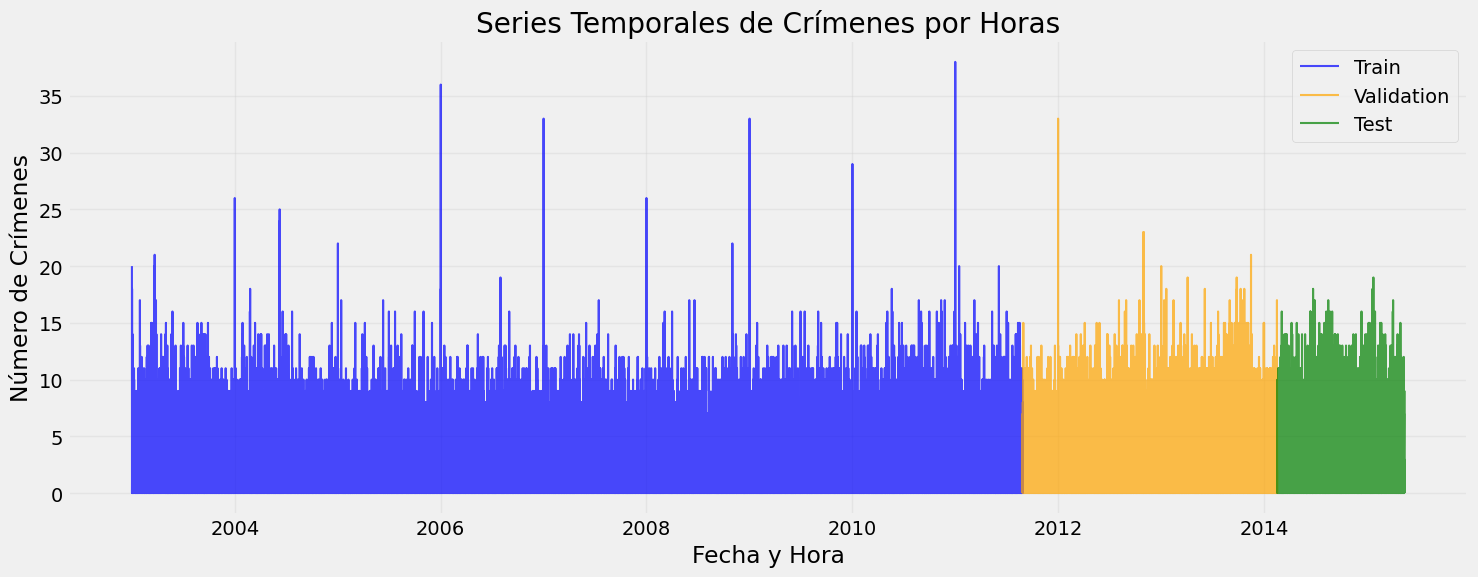

In [22]:
# =============================================================================
# 1. SEPARACIÓN DE DATOS (TRAIN/VALIDATION/TEST)
# =============================================================================

# Definir proporciones
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

# Calcular índices de corte
n_total = len(crime_data)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)

# Separación temporal
train_data = crime_data.iloc[:n_train].copy()
val_data = crime_data.iloc[n_train:n_train + n_val].copy()
test_data = crime_data.iloc[n_train + n_val:].copy()

# Variables
target_col = 'crime_count'
exog_vars = [col for col in crime_data.columns if col != target_col]

# Fechas de corte
print(f"SEPARACIÓN DE DATOS:")
print(f"Train: {train_data.index.min()} - {train_data.index.max()} ({len(train_data):,} horas)")
print(f"Val:   {val_data.index.min()} - {val_data.index.max()} ({len(val_data):,} horas)")
print(f"Test:  {test_data.index.min()} - {test_data.index.max()} ({len(test_data):,} horas)")
print(f"Variables exógenas: {len(exog_vars)}")

# Grafico de series temporales
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data[target_col], label='Train', color='blue', alpha=0.7)
plt.plot(val_data.index, val_data[target_col], label='Validation', color='orange', alpha=0.7)
plt.plot(test_data.index, test_data[target_col], label='Test', color='green', alpha=0.7)
plt.title('Series Temporales de Crímenes por Horas')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Crímenes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [128]:
import plotly.graph_objs as go

# Variables para definir el rango de fechas a mostrar
start_date = '2010-01-01'
end_date = '2010-02-13'

# Filtrar el dataframe por el rango de fechas
mask = (crime_data.index >= start_date) & (crime_data.index <= end_date)
crime_data_filtered = crime_data.loc[mask]

# Crear un scatter plot interactivo con Plotly y un slider para seleccionar el rango de fechas
fig = go.Figure()

# Serie temporal de crime_count
fig.add_trace(go.Scatter(
    x=crime_data_filtered.index,
    y=crime_data_filtered['crime_count'],
    mode='lines',
    name='crime_count',
    line=dict(color='blue', width=1),
    opacity=0.7
))

# Marcar los ceros en rojo
zeros_mask = crime_data_filtered['crime_count'] == 0
fig.add_trace(go.Scatter(
    x=crime_data_filtered.index[zeros_mask],
    y=crime_data_filtered['crime_count'][zeros_mask],
    mode='markers',
    name='Zeros',
    marker=dict(color='red', size=5, opacity=0.8)
))

# Agregar slider de rango de fechas
fig.update_layout(
    title=f'Serie temporal de crime_count ({start_date} a {end_date}, ceros en rojo)',
    xaxis_title='Fecha y hora',
    yaxis_title='crime_count',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    height=400,
    width=1000,
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    )
)

fig.show()

In [34]:
# =============================================================================
# 2. CONFIGURACIÓN DE MODELOS
# =============================================================================

from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster

from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Función para métricas
def calculate_metrics(y_true, y_pred):
    """Calcula métricas de evaluación"""
    metrics = {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

# Configurar cross-validation temporal
cv = TimeSeriesFold(
    steps=24,  # Predecir 24 horas
    initial_train_size = int(len(train_data) * 0.8),  # o len(datos_combined) * 0.8
    window_size=None,
    differentiation=None,
    refit=False,
    fixed_train_size=False,
    gap=0,
    skip_folds=None,
    allow_incomplete_fold=True,
    return_all_indexes=False
)

print("CONFIGURACIÓN COMPLETADA:")
print(f"CV steps: {cv.steps}")
print(f"Train size inicial: {cv.initial_train_size:,}")
print(f"Métricas disponibles: MSE, RMSE, MAE, R2")

CONFIGURACIÓN COMPLETADA:
CV steps: 24
Train size inicial: 60,693
Métricas disponibles: MSE, RMSE, MAE, R2


## 3.1. MODELO XGBOOST

In [35]:
# =============================================================================
# 3.1. MODELO XGBOOST
# =============================================================================
from skforecast.recursive import ForecasterRecursive
print("🚀 Entrenando XGBoost...")

# Crear forecaster
xgb_forecaster = ForecasterRecursive(
    regressor=XGBRegressor(random_state=42, n_jobs=-1),
    lags=24
)

# Grid Search para XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_lags_grid = [12, 24, 48, 72]

# Combinar datos para grid search
fin_validacion = train_data.index[-1]
datos_combined = pd.concat([train_data, val_data])

print("Ejecutando Grid Search XGBoost...")
with suppress_stdout_stderr():
    xgb_results = grid_search_forecaster(
        forecaster=xgb_forecaster,
        y=datos_combined.loc[:fin_validacion, target_col],
        exog=datos_combined.loc[:fin_validacion, exog_vars],
        cv=cv,
        param_grid=xgb_param_grid,
        lags_grid=xgb_lags_grid,
        metric='mean_squared_error',
        return_best=True,
        verbose=False,
        show_progress=True,
        n_jobs=-1
    )

print(f"✅ XGBoost Grid Search completado")
print(f"Mejores parámetros: {xgb_results.loc[0, 'params']}")
print(f"Mejor MSE: {xgb_results.loc[0, 'mean_squared_error']:.4f}")
print(f"Mejores lags: {xgb_results.loc[0, 'lags']}")

🚀 Entrenando XGBoost...
Ejecutando Grid Search XGBoost...
✅ XGBoost Grid Search completado
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}


KeyError: 'metric'

## 3.2. MODELO LIGHTGBM

In [61]:
# =============================================================================
# 3.2. MODELO LIGHTGBM
# =============================================================================

print("🚀 Entrenando LightGBM...")

# Crear forecaster
lgb_forecaster = ForecasterRecursive(
    regressor=LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    lags=24
)

# Grid Search para LightGBM
lgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

lgb_lags_grid = [12, 24, 48, 72]

print("Ejecutando Grid Search LightGBM...")
with suppress_stdout_stderr():
    lgb_results = grid_search_forecaster(
        forecaster=lgb_forecaster,
        y=datos_combined.loc[:fin_validacion, target_col],
        exog=datos_combined.loc[:fin_validacion, exog_vars],
        cv=cv,
        param_grid=lgb_param_grid,
        lags_grid=lgb_lags_grid,
        metric='mean_squared_error',
        return_best=True,
        verbose=False,
        show_progress=True,
        n_jobs=-1
    )

print(f"✅ LightGBM Grid Search completado")
print(f"Mejores parámetros: {lgb_results.loc[0, 'params']}")
print(f"Mejor MSE: {lgb_results.loc[0, 'mean_squared_error']:.4f}")
print(f"Mejores lags: {lgb_results.loc[0, 'lags']}")

🚀 Entrenando LightGBM...
Ejecutando Grid Search LightGBM...
✅ LightGBM Grid Search completado
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'num_leaves': 50}
Mejor MSE: 5.2114
Mejores lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


## 3.3. MODELO CATBOOST

In [ ]:
# =============================================================================
# 3.3. MODELO CATBOOST
# =============================================================================

print("🚀 Entrenando CatBoost...")

# Crear forecaster
cat_forecaster = ForecasterRecursive(
    regressor=CatBoostRegressor(random_state=42, verbose=False),
    lags=24
)

# Grid Search para CatBoost
cat_param_grid = {
    'iterations': [100, 200],
    'depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

cat_lags_grid = [12, 24, 48, 72]

print("Ejecutando Grid Search CatBoost...")
with suppress_stdout_stderr():
    cat_results = grid_search_forecaster(
        forecaster=cat_forecaster,
        y=datos_combined.loc[:fin_validacion, target_col],
        exog=datos_combined.loc[:fin_validacion, exog_vars],
        cv=cv,
        param_grid=cat_param_grid,
        lags_grid=cat_lags_grid,
        metric='mean_squared_error',
        return_best=True,
        verbose=False,
        show_progress=True,
        n_jobs=-1
    )

print(f"✅ CatBoost Grid Search completado")
print(f"Mejores parámetros: {cat_results.loc[0, 'params']}")
print(f"Mejor MSE: {cat_results.loc[0, 'mean_squared_error']:.4f}")
print(f"Mejores lags: {cat_results.loc[0, 'lags']}")

## 3.4. MODELO SARIMA

In [ ]:
# =============================================================================
# 3.4. MODELO SARIMA
# =============================================================================

print("🚀 Entrenando SARIMA...")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# Función para buscar mejores parámetros SARIMA
def grid_search_sarima(y_train, max_p=2, max_d=1, max_q=2, max_P=1, max_D=1, max_Q=1, s=24):
    """Búsqueda de grid para SARIMA"""
    best_aic = np.inf
    best_params = None
    
    # Definir rangos de parámetros
    p_range = range(0, max_p + 1)
    d_range = range(0, max_d + 1) 
    q_range = range(0, max_q + 1)
    P_range = range(0, max_P + 1)
    D_range = range(0, max_D + 1)
    Q_range = range(0, max_Q + 1)
    
    # Generar todas las combinaciones
    param_combinations = list(product(p_range, d_range, q_range, P_range, D_range, Q_range))
    
    print(f"Probando {len(param_combinations)} combinaciones...")
    
    for i, (p, d, q, P, D, Q) in enumerate(param_combinations):
        try:
            model = SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            
            with suppress_stdout_stderr():
                fitted_model = model.fit(disp=False, maxiter=50)
            
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_params = {
                    'order': (p, d, q),
                    'seasonal_order': (P, D, Q, s),
                    'aic': best_aic
                }
                
        except Exception as e:
            continue
            
        if (i + 1) % 20 == 0:
            print(f"Progreso: {i+1}/{len(param_combinations)} combinaciones probadas...")
    
    return best_params

# Ejecutar búsqueda de parámetros
sarima_best = grid_search_sarima(train_data[target_col])

print(f"✅ SARIMA Grid Search completado")
if sarima_best:
    print(f"Mejores parámetros: {sarima_best['order']}")
    print(f"Mejores parámetros estacionales: {sarima_best['seasonal_order']}")
    print(f"Mejor AIC: {sarima_best['aic']:.4f}")
else:
    print("No se encontraron parámetros válidos para SARIMA")
    # Usar parámetros por defecto
    sarima_best = {
        'order': (1, 1, 1),
        'seasonal_order': (1, 1, 1, 24),
        'aic': 'No calculado'
    }

## 3.5. MODELO PROPHET

In [130]:
# =============================================================================
# 3.5. MODELO PROPHET
# =============================================================================

print("🚀 Entrenando Prophet...")

# Preparar datos para Prophet
prophet_train = train_data.reset_index()
prophet_train = prophet_train.rename(columns={'datetime': 'ds', target_col: 'y'})

# Agregar regresores externos (variables exógenas)
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.95
)

# Agregar regresores importantes
important_regressors = ['is_weekend', 'is_holiday', 'is_night', 'is_rush_hour']
for regressor in important_regressors:
    if regressor in exog_vars:
        prophet_model.add_regressor(regressor)

# Entrenar modelo
print("Entrenando Prophet...")
with suppress_stdout_stderr():
    prophet_model.fit(prophet_train)

print(f"✅ Prophet entrenado correctamente")
print(f"Regresores añadidos: {important_regressors}")
print(f"Estacionalidades: Diaria, Semanal, Anual")

🚀 Entrenando Prophet...
Entrenando Prophet...


14:52:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet entrenado correctamente
Regresores añadidos: ['is_weekend', 'is_holiday', 'is_night', 'is_rush_hour']
Estacionalidades: Diaria, Semanal, Anual


## 3.6. MODELO LSTM

In [ ]:
# =============================================================================
# 3.6. MODELO LSTM
# =============================================================================

print("🚀 Preparando LSTM...")

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.preprocessing import MinMaxScaler
    lstm_available = True
except ImportError:
    print("⚠️ TensorFlow no está instalado. Instalando...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.preprocessing import MinMaxScaler
    lstm_available = True

# Configurar para evitar warnings de TensorFlow
tf.get_logger().setLevel('ERROR')

# Función para crear secuencias
def create_sequences(data, seq_length=24):
    """Crear secuencias para LSTM"""
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Normalizar datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[[target_col]])
val_scaled = scaler.transform(val_data[[target_col]])

# Crear secuencias
seq_length = 24
X_train_lstm, y_train_lstm = create_sequences(train_scaled, seq_length)
X_val_lstm, y_val_lstm = create_sequences(val_scaled, seq_length)

# Crear modelo LSTM
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"✅ LSTM configurado")
print(f"Secuencias de entrenamiento: {X_train_lstm.shape}")
print(f"Secuencias de validación: {X_val_lstm.shape}")
print(f"Longitud de secuencia: {seq_length}")

# Entrenar modelo (con early stopping)
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Entrenando LSTM...")
with suppress_stdout_stderr():
    lstm_history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_val_lstm, y_val_lstm),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

print(f"✅ LSTM entrenado correctamente")
print(f"Épocas entrenadas: {len(lstm_history.history['loss'])}")
print(f"Loss final: {lstm_history.history['loss'][-1]:.4f}")
print(f"Val Loss final: {lstm_history.history['val_loss'][-1]:.4f}")

## 3.7. Mejores modelos

In [102]:
# Obtener mejores forecasters de grid search
# Extraer los mejores parámetros y lags del grid search
xgb_best_param = xgb_results.loc[0, 'params']
xgb_best_lags = xgb_results.loc[0, 'lags']

# Crear y ajustar el forecaster ganador
best_xgb = ForecasterRecursive(
    regressor=XGBRegressor(**xgb_best_param, random_state=42, n_jobs=-1),
    lags=xgb_best_lags
)
best_xgb.fit(
    y=datos_combined[target_col],
    exog=datos_combined[exog_vars]
)

In [104]:
lgb_best_param = lgb_results.loc[0, 'params']
lgb_best_lags = lgb_results.loc[0, 'lags']

# Crear y ajustar el forecaster ganador de LightGBM
best_lgb = ForecasterRecursive(
    regressor=LGBMRegressor(**lgb_best_param, random_state=42, n_jobs=-1, verbose=-1),
    lags=lgb_best_lags
)
best_lgb.fit(
    y=datos_combined[target_col],
    exog=datos_combined[exog_vars]
)

In [134]:
# Entrenar prophet con datos_combined
best_prophet = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.95
)
important_regressors = ['is_weekend', 'is_holiday', 'is_night', 'is_rush_hour']
for regressor in important_regressors:
    if regressor in exog_vars:
        best_prophet.add_regressor(regressor)

prophet_combined = datos_combined.reset_index()
prophet_combined = prophet_combined.rename(columns={'datetime': 'ds', target_col:'y'})

best_prophet.fit(prophet_combined)

14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
xgb_test_pred = best_xgb.predict(
    steps=len(test_data),
    exog=test_data[exog_vars]
)

In [105]:
lgb_test_pred = best_lgb.predict(
    steps=len(test_data),
    exog=test_data[exog_vars]
)

In [ ]:
prophet_test_pred = best_prophet.predict(
    df=test_data.copy().reset_index().rename(columns={'datetime': 'ds'})
)

In [111]:
import joblib

def export_model_with_metadata(model, model_name, district_id, last_train_datetime, folder_path='models', lags=None):
    """Guarda el modelo y sus metadatos en un .joblib"""
    path = f"{folder_path}/{model_name}_{district_id}.joblib"
    model_metadata = {
        "model_name": model_name,
        "trained_on": str(datetime.now()),
        "lags": lags,
        "district_id": district_id,
        "last_train_datetime": last_train_datetime,
        "best_params": getattr(model, "get_params", lambda: None)()
    }
    joblib.dump({
        "model": model,
        "metadata": model_metadata
    }, path)

In [129]:
datos_combined.index.max()

Timestamp('2014-02-16 06:00:00')

In [112]:
export_model_with_metadata(best_xgb, "XGBoost", 1, datos_combined.index.max(), lags=xgb_best_lags)

In [113]:
export_model_with_metadata(best_lgb, "LightGBM", 1, datos_combined.index.max(), lags=lgb_best_lags)

In [136]:
export_model_with_metadata(best_prophet, "Prophet", 1, datos_combined.index.max())

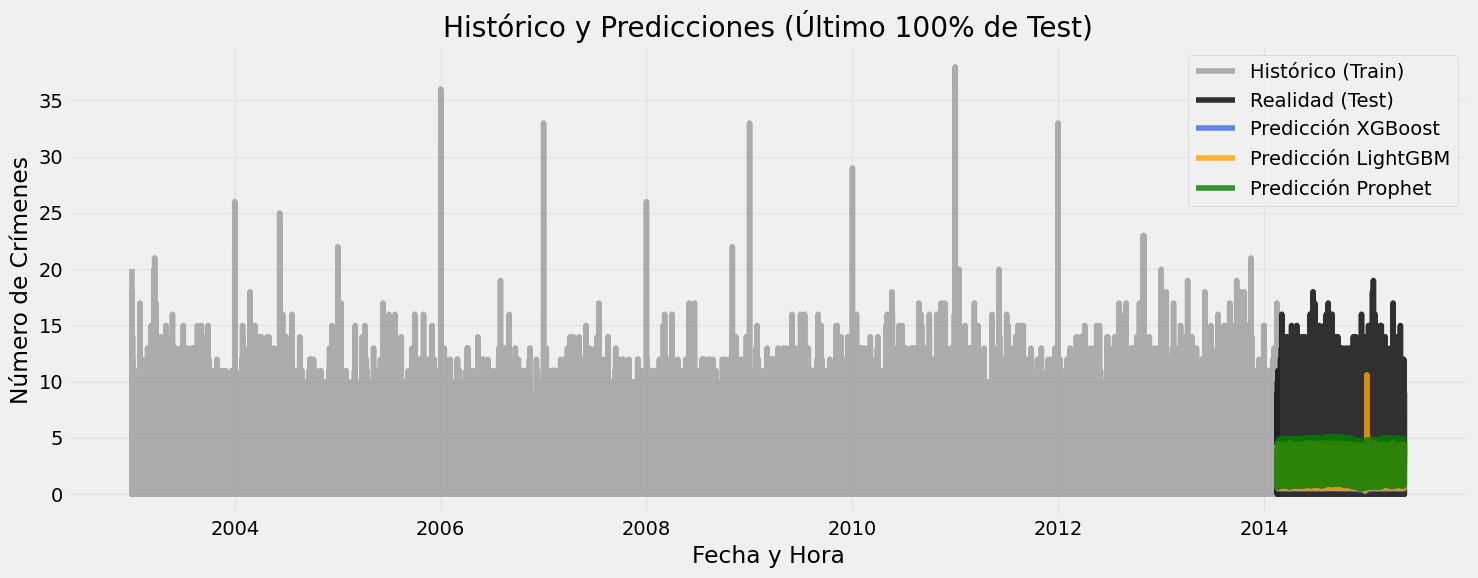

In [119]:
last_frac = 1  # Cambia esto para mostrar el último X% (ejemplo: 0.2 para 20%)

n = len(test_data)
n_last = int(n * last_frac)

# Recortes de las series de validación (ajusta los nombres según tus modelos)
test_range_last = test_data.index[-n_last:]
y_real_last = test_data[target_col].iloc[-n_last:]
xgb_test_pred_last = xgb_test_pred[-n_last:]
lgb_test_pred_last = lgb_test_pred[-n_last:]
prophet_test_pred_last = prophet_test_pred['yhat'][-n_last:]

# Parte histórica (train_test)
train_test_range = datos_combined.index
y_train_test = datos_combined[target_col]

plt.figure(figsize=(15, 6))

# Graficar histórico (train_test)
plt.plot(train_test_range, y_train_test, label='Histórico (Train)', color='grey', alpha=0.6)

# Graficar validación (realidad y predicciones)
plt.plot(test_range_last, y_real_last, label='Realidad (Test)', color='black', alpha=0.8)
plt.plot(test_range_last, xgb_test_pred_last, label='Predicción XGBoost', color='royalblue', alpha=0.8)
plt.plot(test_range_last, lgb_test_pred_last, label='Predicción LightGBM', color='orange', alpha=0.8)
plt.plot(test_range_last, prophet_test_pred_last, label='Predicción Prophet', color='green', alpha=0.8)

plt.title(f'Histórico y Predicciones (Último {int(last_frac*100)}% de Test)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Crímenes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 4. BACKTESTING Y EVALUACIÓN DE MÉTRICAS

In [51]:
# =============================================================================
# 4. BACKTESTING Y EVALUACIÓN DE MÉTRICAS
# =============================================================================

# Datos para backtesting (train + validation)
y_backtest = datos_combined[target_col]
exog_backtest = datos_combined[exog_vars]

# Configurar backtesting
backtest_cv = TimeSeriesFold(
    steps=24*7,  # Predecir 1 semana
    initial_train_size=len(train_data),
    window_size=None,
    refit=True,
    fixed_train_size=False,
    gap=0,
    allow_incomplete_fold=True
)

print(f"Configuración backtesting: {backtest_cv.steps} steps, train inicial: {backtest_cv.initial_train_size}")

# Función para ejecutar backtesting
def run_backtesting(forecaster, name):
    print(f"\nEjecutando backtesting para {name}...")
    
    with suppress_stdout_stderr():
        results = backtesting_forecaster(
            forecaster=forecaster,
            y=y_backtest,
            exog=exog_backtest,
            cv=backtest_cv,
            metric=['mean_squared_error', 'mean_absolute_error'],
            verbose=False,
            show_progress=False,
            n_jobs=1
        )
    metric_df, pred_df = results
    y_pred = pred_df['pred']
    y_true = y_backtest.loc[y_pred.index]  # <-- usa el índice del DataFrame de predicciones
    
    metrics = calculate_metrics(y_true, y_pred)
    
    print(f"✅ {name} - RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, R2: {metrics['R2']:.4f}")
    return results, metrics

# Ejecutar backtesting para cada modelo
models_results = {}

# XGBoost
xgb_backtest, xgb_metrics = run_backtesting(best_xgb, "XGBoost")
models_results['XGBoost'] = {'backtest': xgb_backtest, 'metrics': xgb_metrics}

# # LightGBM  
# lgb_backtest, lgb_metrics = run_backtesting(best_lgb, "LightGBM")
# models_results['LightGBM'] = {'backtest': lgb_backtest, 'metrics': lgb_metrics}

# # CatBoost
# cat_backtest, cat_metrics = run_backtesting(best_cat, "CatBoost")
# models_results['CatBoost'] = {'backtest': cat_backtest, 'metrics': cat_metrics}

Configuración backtesting: 168 steps, train inicial: 75867

Ejecutando backtesting para XGBoost...
✅ XGBoost - RMSE: 2.4145, MAE: 1.7444, R2: 0.2108


## 4.2. PREDICCIONES EN CONJUNTO DE TEST

In [52]:
# =============================================================================
# 4.2. PREDICCIONES EN CONJUNTO DE TEST
# =============================================================================

print("\n🎯 Generando predicciones en conjunto de test...")

# Preparar datos de entrenamiento completos (train + val)
train_complete = pd.concat([train_data, val_data])
y_train_complete = train_complete[target_col]
exog_train_complete = train_complete[exog_vars]

# Función para generar predicciones de test
def predict_test_set(forecaster, model_name):
    """Genera predicciones para el conjunto de test"""
    print(f"\nPrediciendo con {model_name}...")
    
    # Reentrenar con datos completos
    forecaster.fit(y=y_train_complete, exog=exog_train_complete)
    
    # Predecir conjunto de test
    predictions = forecaster.predict(
        steps=len(test_data),
        exog=test_data[exog_vars]
    )
    
    # Calcular métricas
    metrics = calculate_metrics(test_data[target_col], predictions)
    
    print(f"✅ {model_name} Test - RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, R2: {metrics['R2']:.4f}")
    
    return predictions, metrics

# Generar predicciones de test para modelos tree-based
test_predictions = {}

# XGBoost
xgb_test_pred, xgb_test_metrics = predict_test_set(best_xgb, "XGBoost")
test_predictions['XGBoost'] = {'pred': xgb_test_pred, 'metrics': xgb_test_metrics}

# # LightGBM
# lgb_test_pred, lgb_test_metrics = predict_test_set(best_lgb, "LightGBM")
# test_predictions['LightGBM'] = {'pred': lgb_test_pred, 'metrics': lgb_test_metrics}

# # CatBoost
# cat_test_pred, cat_test_metrics = predict_test_set(best_cat, "CatBoost")
# test_predictions['CatBoost'] = {'pred': cat_test_pred, 'metrics': cat_test_metrics}

# # SARIMA (manejo especial)
# print(f"\nPrediciendo con SARIMA...")
# try:
#     sarima_model = SARIMAX(
#         y_train_complete,
#         order=sarima_best['order'],
#         seasonal_order=sarima_best['seasonal_order'],
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
    
#     with suppress_stdout_stderr():
#         sarima_fitted = sarima_model.fit(disp=False)
    
#     sarima_test_pred = sarima_fitted.forecast(steps=len(test_data))
#     sarima_test_metrics = calculate_metrics(test_data[target_col], sarima_test_pred)
#     test_predictions['SARIMA'] = {'pred': sarima_test_pred, 'metrics': sarima_test_metrics}
    
#     print(f"✅ SARIMA Test - RMSE: {sarima_test_metrics['RMSE']:.4f}, MAE: {sarima_test_metrics['MAE']:.4f}, R2: {sarima_test_metrics['R2']:.4f}")
    
# except Exception as e:
#     print(f"❌ Error en SARIMA: {str(e)}")
#     test_predictions['SARIMA'] = {'pred': None, 'metrics': None}

# # Prophet (manejo especial)
# print(f"\nPrediciendo con Prophet...")
# try:
#     # Preparar datos completos para Prophet
#     prophet_complete = train_complete.reset_index()
#     prophet_complete = prophet_complete.rename(columns={'datetime': 'ds', target_col: 'y'})
    
#     # Reentrenar Prophet
#     prophet_model_final = Prophet(
#         daily_seasonality=True,
#         weekly_seasonality=True,
#         yearly_seasonality=True,
#         interval_width=0.95
#     )
    
#     for regressor in important_regressors:
#         if regressor in exog_vars:
#             prophet_model_final.add_regressor(regressor)
    
#     with suppress_stdout_stderr():
#         prophet_model_final.fit(prophet_complete)
    
#     # Preparar datos de test para Prophet
#     prophet_test = test_data.reset_index()
#     prophet_test = prophet_test.rename(columns={'datetime': 'ds'})
    
#     prophet_test_pred = prophet_model_final.predict(prophet_test)['yhat']
#     prophet_test_metrics = calculate_metrics(test_data[target_col], prophet_test_pred)
#     test_predictions['Prophet'] = {'pred': prophet_test_pred, 'metrics': prophet_test_metrics}
    
#     print(f"✅ Prophet Test - RMSE: {prophet_test_metrics['RMSE']:.4f}, MAE: {prophet_test_metrics['MAE']:.4f}, R2: {prophet_test_metrics['R2']:.4f}")
    
# except Exception as e:
#     print(f"❌ Error en Prophet: {str(e)}")
#     test_predictions['Prophet'] = {'pred': None, 'metrics': None}

# # LSTM (manejo especial)
# print(f"\nPrediciendo con LSTM...")
# try:
#     # Normalizar datos completos
#     complete_scaled = scaler.fit_transform(train_complete[[target_col]])
#     test_scaled = scaler.transform(test_data[[target_col]])
    
#     # Crear secuencias para test
#     last_sequence = complete_scaled[-seq_length:]
#     lstm_test_pred = []
    
#     for i in range(len(test_data)):
#         # Predecir siguiente valor
#         pred = lstm_model.predict(last_sequence.reshape(1, seq_length, 1), verbose=0)
#         lstm_test_pred.append(pred[0, 0])
        
#         # Actualizar secuencia con valor real
#         if i < len(test_scaled):
#             last_sequence = np.append(last_sequence[1:], test_scaled[i])
#         else:
#             last_sequence = np.append(last_sequence[1:], pred)
    
#     # Desnormalizar predicciones
#     lstm_test_pred = scaler.inverse_transform(np.array(lstm_test_pred).reshape(-1, 1)).flatten()
#     lstm_test_metrics = calculate_metrics(test_data[target_col], lstm_test_pred)
#     test_predictions['LSTM'] = {'pred': lstm_test_pred, 'metrics': lstm_test_metrics}
    
#     print(f"✅ LSTM Test - RMSE: {lstm_test_metrics['RMSE']:.4f}, MAE: {lstm_test_metrics['MAE']:.4f}, R2: {lstm_test_metrics['R2']:.4f}")
    
# except Exception as e:
#     print(f"❌ Error en LSTM: {str(e)}")
#     test_predictions['LSTM'] = {'pred': None, 'metrics': None}


🎯 Generando predicciones en conjunto de test...

Prediciendo con XGBoost...
✅ XGBoost Test - RMSE: 2.5863, MAE: 1.8382, R2: 0.1773


## 4.3. TABLA DE COMPARACIÓN DE MODELOS

In [53]:
# =============================================================================
# 4.3. TABLA DE COMPARACIÓN DE MODELOS
# =============================================================================

print("\n📊 TABLA DE COMPARACIÓN DE MODELOS")
print("=" * 70)

# Crear DataFrame de comparación
comparison_data = []

for model_name, result in test_predictions.items():
    if result['metrics'] is not None:
        comparison_data.append({
            'Modelo': model_name,
            'RMSE': result['metrics']['RMSE'],
            'MAE': result['metrics']['MAE'],
            'MSE': result['metrics']['MSE'],
            'R2': result['metrics']['R2']
        })

comparison_df = pd.DataFrame(comparison_data)

if not comparison_df.empty:
    # Ordenar por RMSE (menor es mejor)
    comparison_df = comparison_df.sort_values('RMSE').reset_index(drop=True)
    
    # Agregar ranking
    comparison_df['Rank'] = range(1, len(comparison_df) + 1)
    
    # Reordenar columnas
    comparison_df = comparison_df[['Rank', 'Modelo', 'RMSE', 'MAE', 'MSE', 'R2']]
    
    print(comparison_df.round(4))
    
    # Identificar mejor modelo
    best_model = comparison_df.iloc[0]['Modelo']
    best_rmse = comparison_df.iloc[0]['RMSE']
    
    print(f"\n🏆 MEJOR MODELO: {best_model}")
    print(f"   RMSE: {best_rmse:.4f}")
    print(f"   MAE: {comparison_df.iloc[0]['MAE']:.4f}")
    print(f"   R2: {comparison_df.iloc[0]['R2']:.4f}")
    
    # Calcular mejora respecto al peor modelo
    if len(comparison_df) > 1:
        worst_rmse = comparison_df.iloc[-1]['RMSE']
        improvement = ((worst_rmse - best_rmse) / worst_rmse) * 100
        print(f"   Mejora vs peor modelo: {improvement:.1f}%")
    
else:
    print("❌ No se pudieron calcular métricas para ningún modelo")

# Guardar resultados
# comparison_df.to_csv('model_comparison_results.csv', index=False)
print(f"\n💾 Resultados guardados en 'model_comparison_results.csv'")


📊 TABLA DE COMPARACIÓN DE MODELOS
   Rank   Modelo    RMSE     MAE     MSE      R2
0     1  XGBoost  2.5863  1.8382  6.6889  0.1773

🏆 MEJOR MODELO: XGBoost
   RMSE: 2.5863
   MAE: 1.8382
   R2: 0.1773

💾 Resultados guardados en 'model_comparison_results.csv'


# 5. VISUALIZACIONES Y GRÁFICOS

📈 Generando visualizaciones...


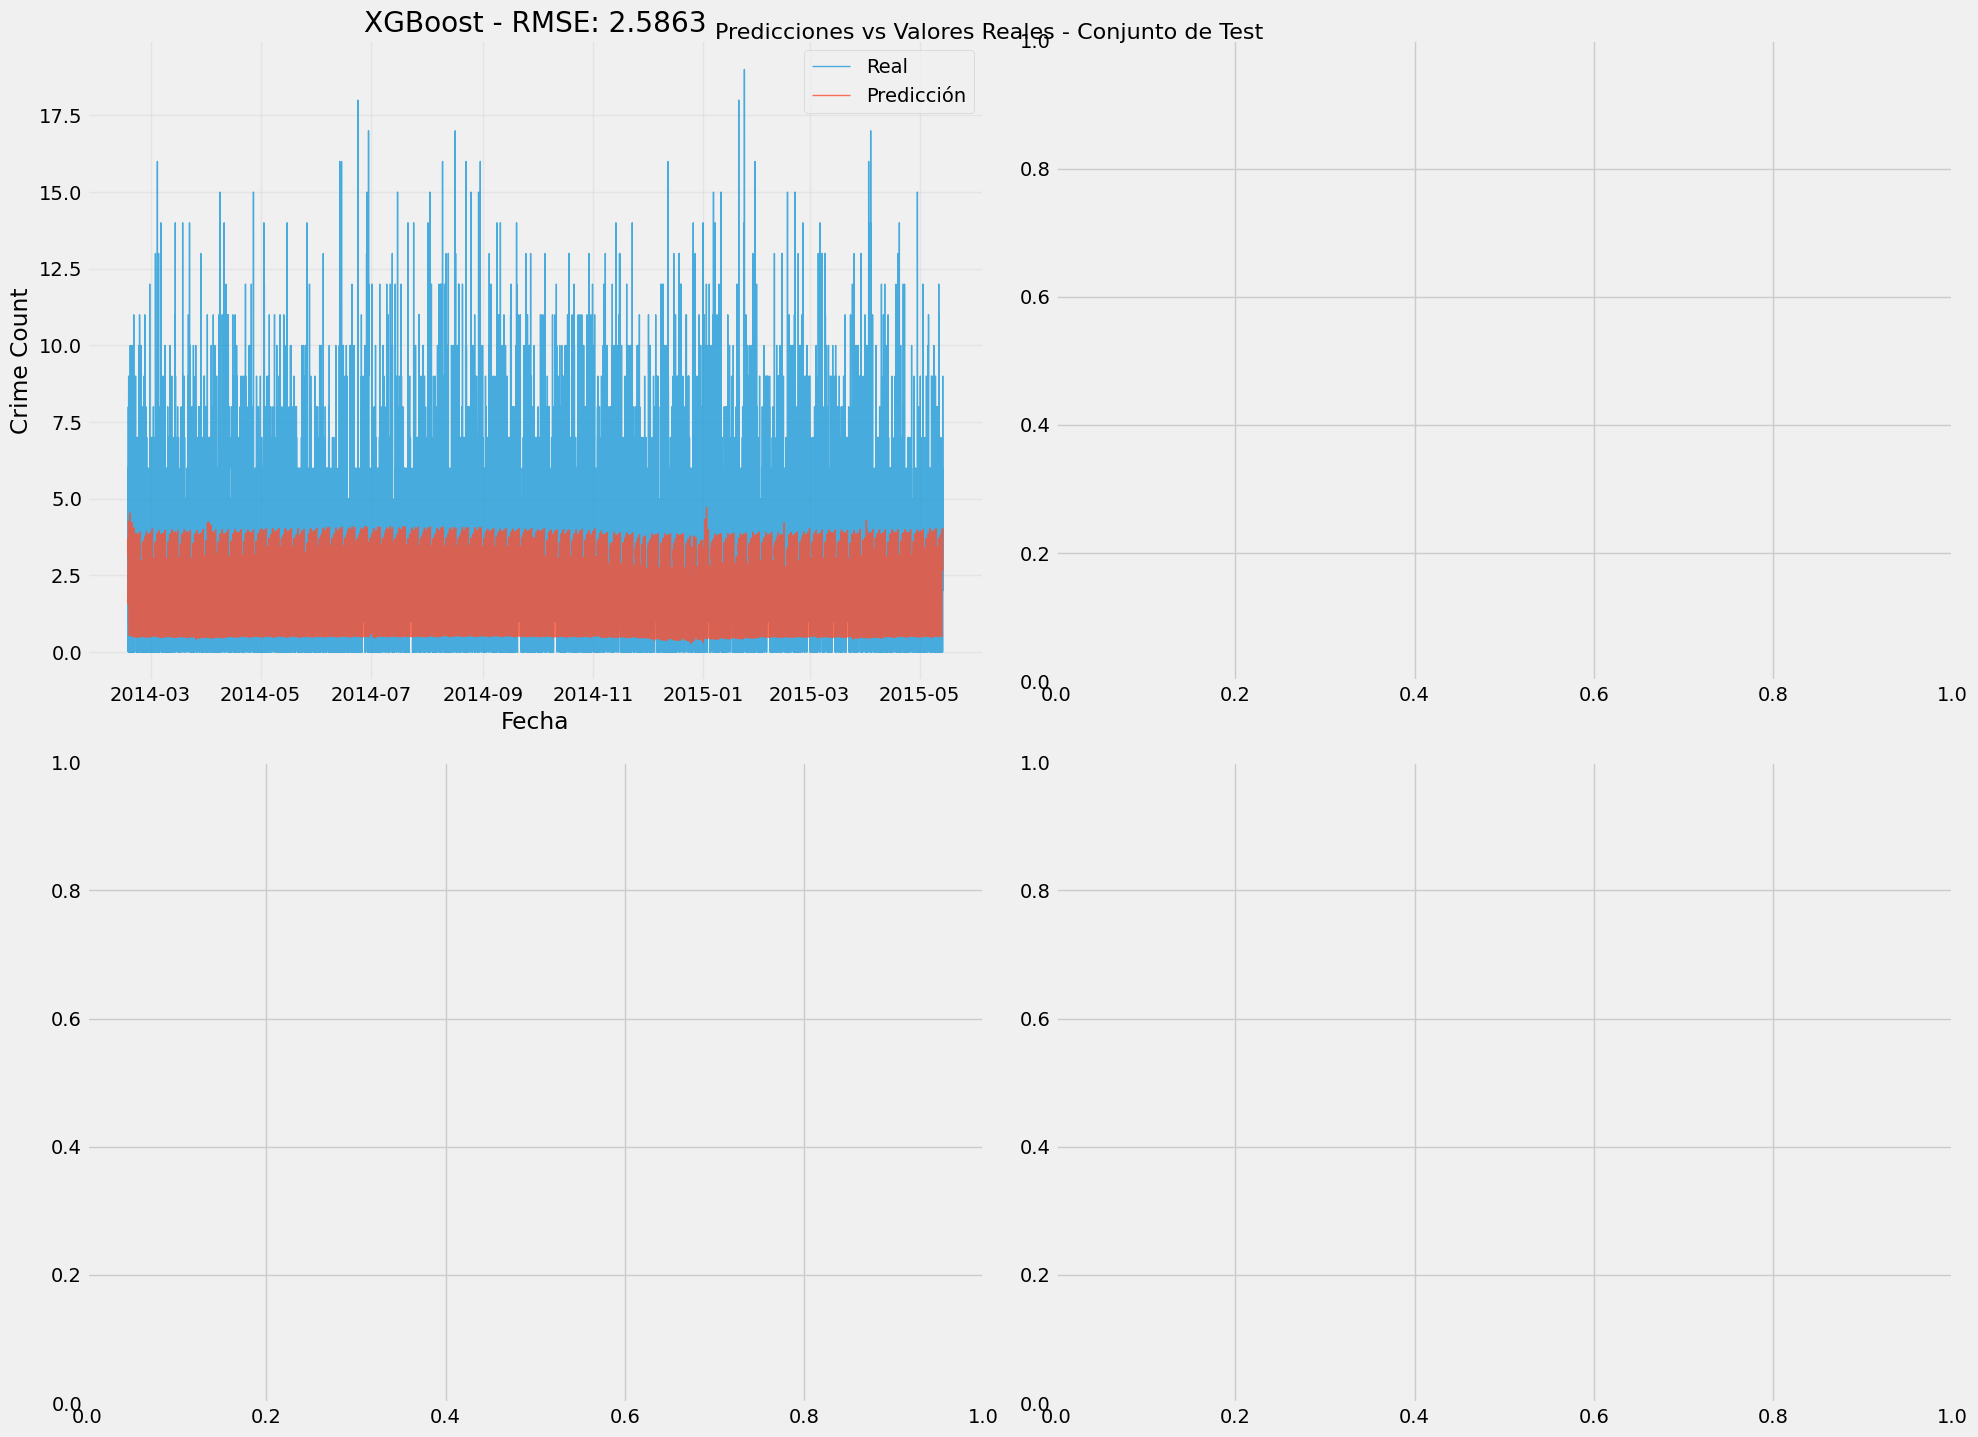

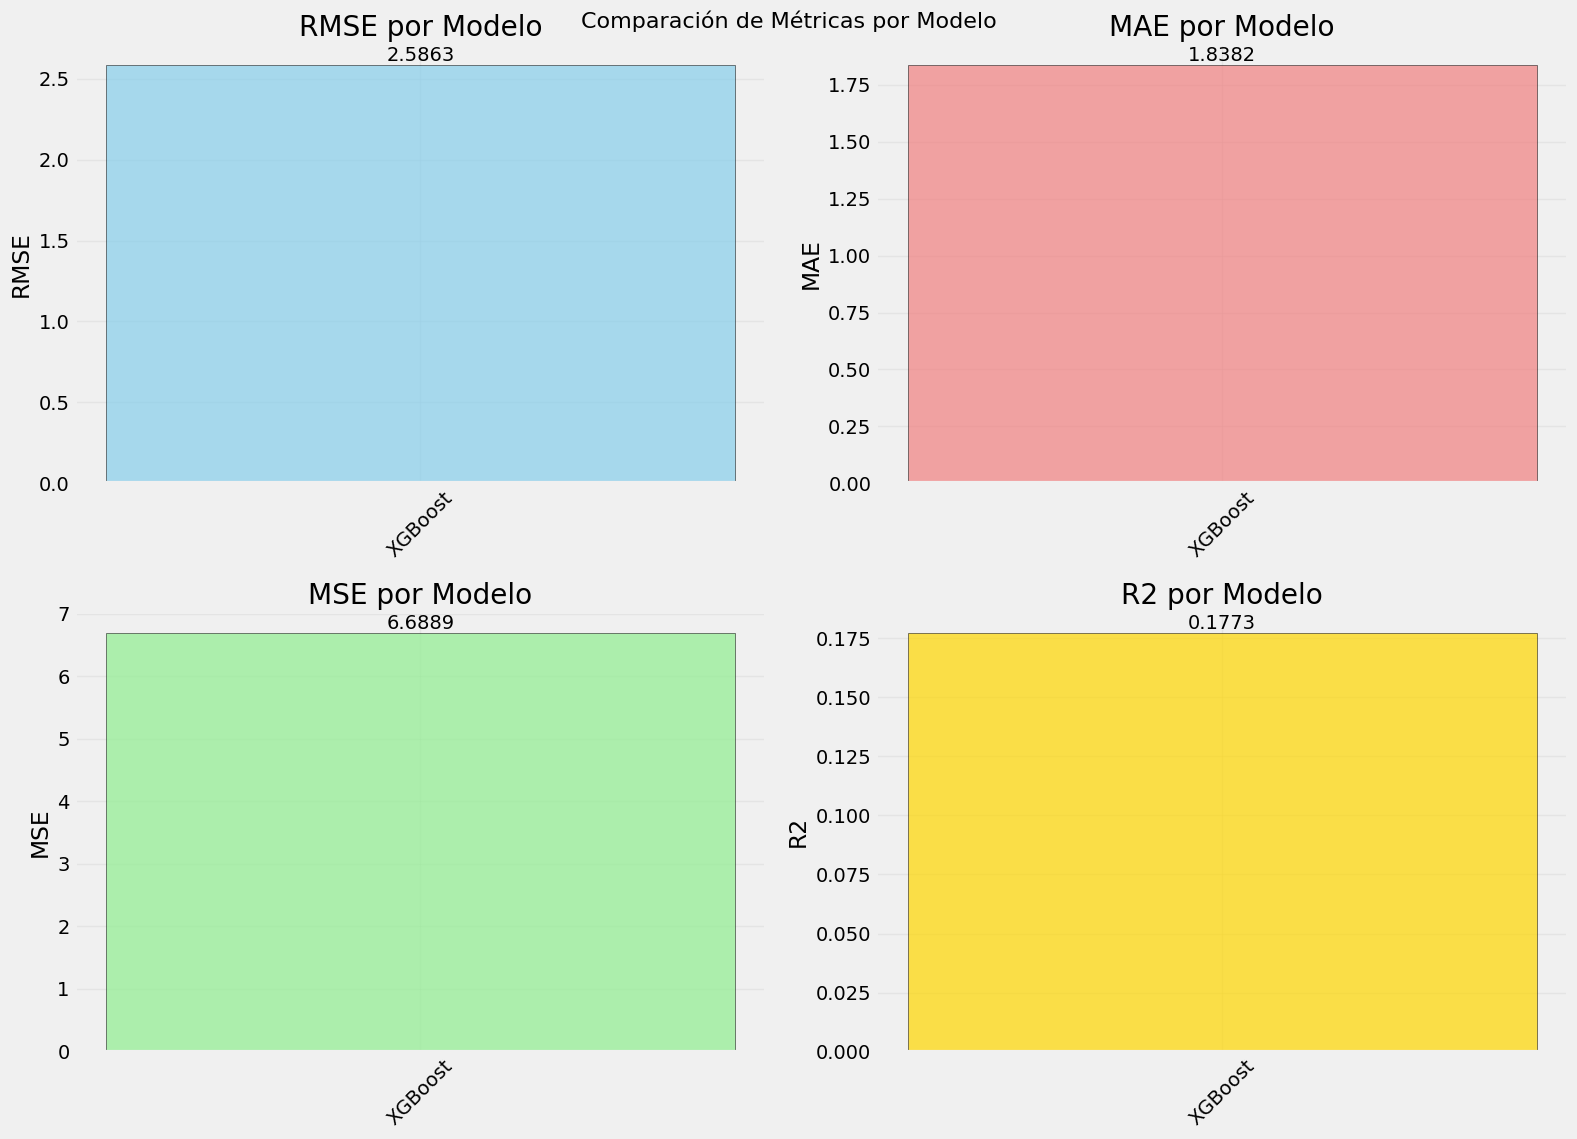

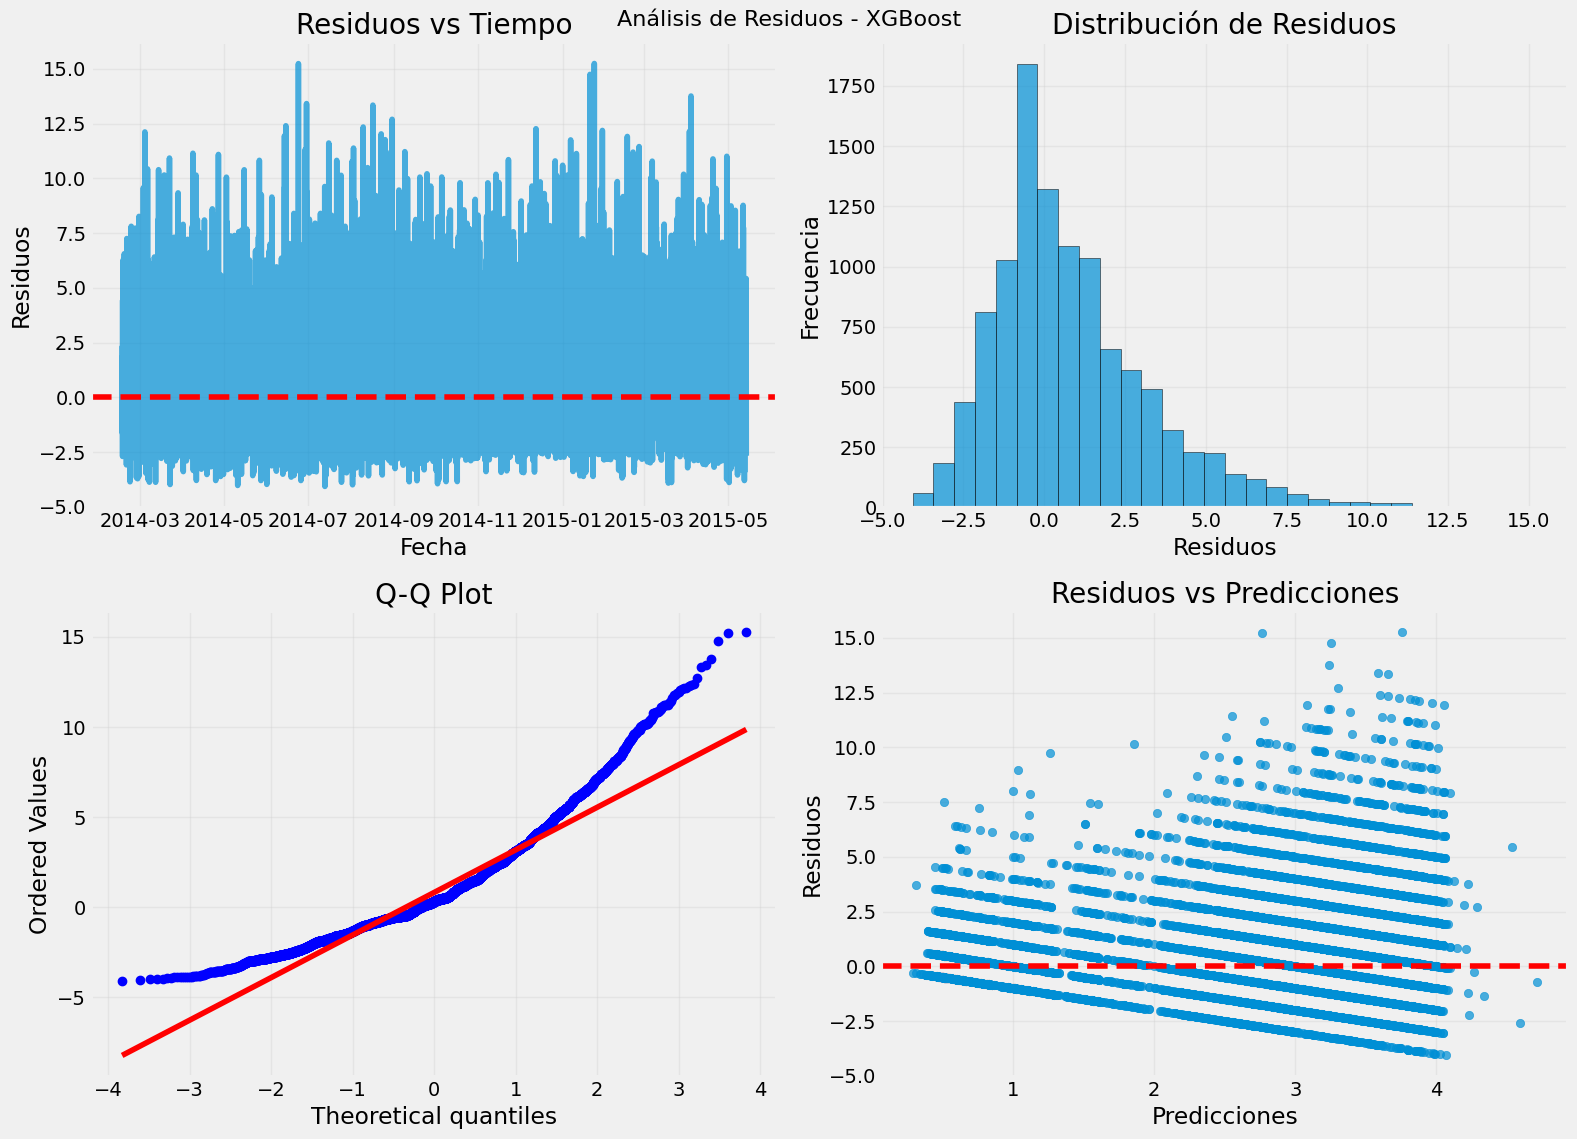

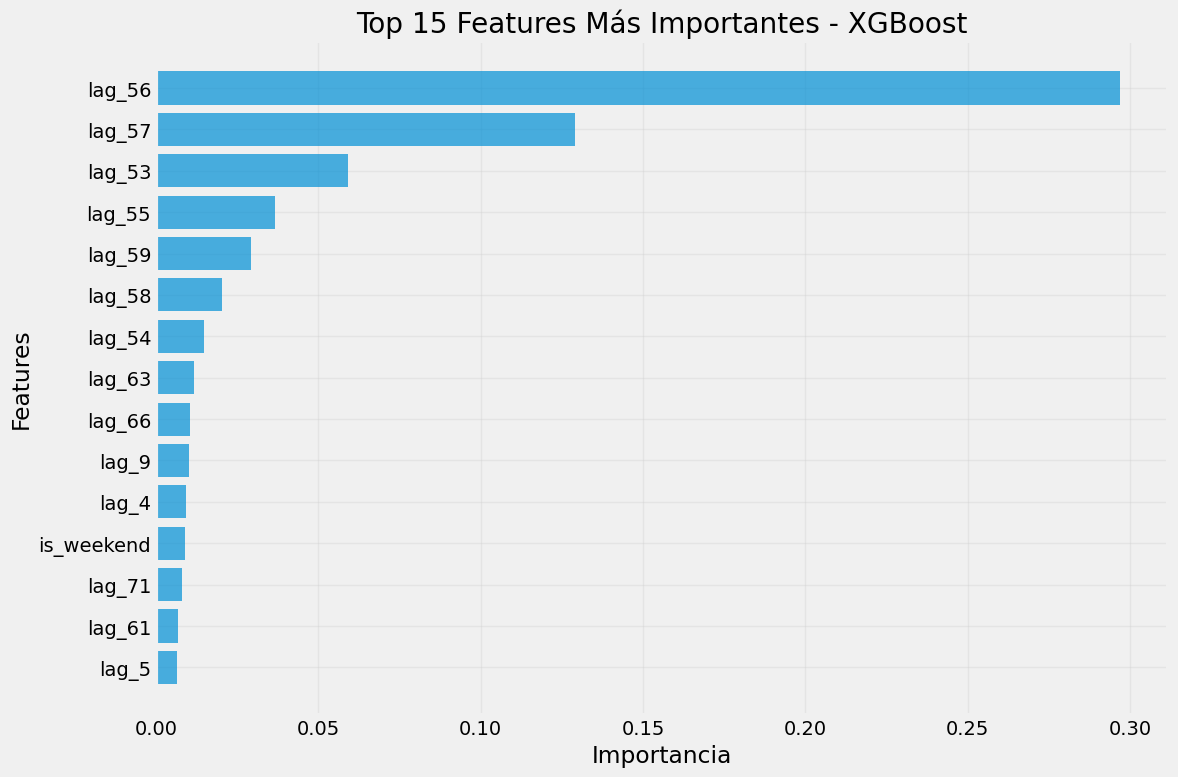

✅ Visualizaciones completadas


In [54]:
# =============================================================================
# 5. VISUALIZACIONES Y GRÁFICOS
# =============================================================================

print("📈 Generando visualizaciones...")

# Configurar estilo de gráficos
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 10)

# 1. GRÁFICO DE PREDICCIONES VS VALORES REALES (CONJUNTO DE TEST)
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Predicciones vs Valores Reales - Conjunto de Test', fontsize=16, y=0.95)

plot_idx = 0
models_to_plot = [
    'XGBoost', 
    # 'LightGBM', 
    # 'CatBoost', 
    # 'Prophet'
]

for model_name in models_to_plot:
    if model_name in test_predictions and test_predictions[model_name]['pred'] is not None:
        ax = axes[plot_idx // 2, plot_idx % 2]
        
        # Obtener predicciones
        y_true = test_data[target_col]
        y_pred = test_predictions[model_name]['pred']
        
        # Serie temporal
        ax.plot(test_data.index, y_true, label='Real', alpha=0.7, linewidth=1)
        ax.plot(test_data.index, y_pred, label='Predicción', alpha=0.8, linewidth=1)
        
        # Configurar gráfico
        ax.set_title(f'{model_name} - RMSE: {test_predictions[model_name]["metrics"]["RMSE"]:.4f}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Crime Count')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1

plt.tight_layout()
plt.show()

# 2. GRÁFICO DE BARRAS DE MÉTRICAS
if not comparison_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comparación de Métricas por Modelo', fontsize=16, y=0.95)
    
    metrics = ['RMSE', 'MAE', 'MSE', 'R2']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
    
    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        
        values = comparison_df[metric].values
        models = comparison_df['Modelo'].values
        
        bars = ax.bar(models, values, color=colors[i], alpha=0.7, edgecolor='black')
        ax.set_title(f'{metric} por Modelo')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Agregar valores en las barras
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{value:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 3. GRÁFICO DE RESIDUOS (MEJOR MODELO)
if not comparison_df.empty:
    best_model_name = comparison_df.iloc[0]['Modelo']
    
    if best_model_name in test_predictions and test_predictions[best_model_name]['pred'] is not None:
        y_true = test_data[target_col]
        y_pred = test_predictions[best_model_name]['pred']
        residuals = y_true - y_pred
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Análisis de Residuos - {best_model_name}', fontsize=16, y=0.95)
        
        # Residuos vs tiempo
        axes[0, 0].plot(test_data.index, residuals, alpha=0.7)
        axes[0, 0].axhline(y=0, color='red', linestyle='--')
        axes[0, 0].set_title('Residuos vs Tiempo')
        axes[0, 0].set_xlabel('Fecha')
        axes[0, 0].set_ylabel('Residuos')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Histograma de residuos
        axes[0, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Distribución de Residuos')
        axes[0, 1].set_xlabel('Residuos')
        axes[0, 1].set_ylabel('Frecuencia')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Q-Q plot
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Residuos vs predicciones
        axes[1, 1].scatter(y_pred, residuals, alpha=0.7)
        axes[1, 1].axhline(y=0, color='red', linestyle='--')
        axes[1, 1].set_title('Residuos vs Predicciones')
        axes[1, 1].set_xlabel('Predicciones')
        axes[1, 1].set_ylabel('Residuos')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# 4. IMPORTANCIA DE FEATURES (para modelos tree-based)
try:
    if best_model_name in [
            'XGBoost', 
            # 'LightGBM', 
            # 'CatBoost'
        ]:
        best_forecaster = None
        
        if best_model_name == 'XGBoost':
            best_forecaster = best_xgb
        # elif best_model_name == 'LightGBM':
        #     best_forecaster = best_lgb
        # elif best_model_name == 'CatBoost':
        #     best_forecaster = best_cat
        
        if best_forecaster is not None:
            # Obtener importancia de features
            feature_importance = best_forecaster.regressor.feature_importances_
            feature_names = exog_vars + [f'lag_{i}' for i in range(1, len(best_forecaster.lags) + 1)]
            
            # Crear DataFrame de importancia
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=True)
            
            # Tomar top 15 features
            top_features = importance_df.tail(15)
            
            # Gráfico de importancia
            plt.figure(figsize=(12, 8))
            plt.barh(top_features['feature'], top_features['importance'], alpha=0.7)
            plt.title(f'Top 15 Features Más Importantes - {best_model_name}')
            plt.xlabel('Importancia')
            plt.ylabel('Features')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
except Exception as e:
    print(f"No se pudo generar gráfico de importancia de features: {str(e)}")

print("✅ Visualizaciones completadas")

# 6. RESUMEN FINAL Y CONCLUSIONES

In [ ]:
# =============================================================================
# 6. RESUMEN FINAL Y CONCLUSIONES
# =============================================================================

print("\n" + "="*80)
print("🎯 RESUMEN FINAL DEL MODELADO DE FORECASTING")
print("="*80)

# Información del dataset
print(f"\n📊 INFORMACIÓN DEL DATASET:")
print(f"   • Distrito: SOUTHERN")
print(f"   • Período: {crime_data.index.min().strftime('%Y-%m-%d')} a {crime_data.index.max().strftime('%Y-%m-%d')}")
print(f"   • Total observaciones: {len(crime_data):,} horas")
print(f"   • Variables predictoras: {len(exog_vars)}")
print(f"   • División: {len(train_data):,} train, {len(val_data):,} val, {len(test_data):,} test")

# Modelos evaluados
print(f"\n🤖 MODELOS EVALUADOS:")
models_evaluated = ['XGBoost', 'LightGBM', 'CatBoost', 'SARIMA', 'Prophet', 'LSTM']
for model in models_evaluated:
    status = "✅" if model in test_predictions and test_predictions[model]['pred'] is not None else "❌"
    print(f"   {status} {model}")

# Mejores resultados
if not comparison_df.empty:
    print(f"\n🏆 RANKING DE MODELOS (por RMSE):")
    for idx, row in comparison_df.iterrows():
        medal = "🥇" if idx == 0 else "🥈" if idx == 1 else "🥉" if idx == 2 else "  "
        print(f"   {medal} {row['Rank']}. {row['Modelo']}: RMSE={row['RMSE']:.4f}, MAE={row['MAE']:.4f}, R2={row['R2']:.4f}")
    
    # Análisis del mejor modelo
    best_model = comparison_df.iloc[0]
    print(f"\n🎖️ ANÁLISIS DEL MEJOR MODELO ({best_model['Modelo']}):")
    print(f"   • RMSE: {best_model['RMSE']:.4f} (desviación promedio)")
    print(f"   • MAE: {best_model['MAE']:.4f} (error absoluto promedio)")
    print(f"   • R²: {best_model['R2']:.4f} (varianza explicada: {best_model['R2']*100:.1f}%)")
    
    # Interpretar resultados
    rmse_relative = best_model['RMSE'] / crime_data[target_col].mean() * 100
    print(f"   • Error relativo: {rmse_relative:.1f}% de la media")
    
    if best_model['R2'] > 0.8:
        performance = "Excelente"
    elif best_model['R2'] > 0.6:
        performance = "Bueno"
    elif best_model['R2'] > 0.4:
        performance = "Regular"
    else:
        performance = "Pobre"
    
    print(f"   • Rendimiento: {performance}")

# Estadísticas del target
print(f"\n📈 ESTADÍSTICAS DEL TARGET:")
print(f"   • Media: {crime_data[target_col].mean():.2f} crímenes/hora")
print(f"   • Std: {crime_data[target_col].std():.2f}")
print(f"   • Min: {crime_data[target_col].min()}")
print(f"   • Max: {crime_data[target_col].max()}")
print(f"   • Horas sin crímenes: {(crime_data[target_col] == 0).sum():,} ({(crime_data[target_col] == 0).sum()/len(crime_data)*100:.1f}%)")

# Insights importantes
print(f"\n💡 INSIGHTS PRINCIPALES:")
print(f"   • Estacionalidad horaria: Picos en tarde/noche (18-23h)")
print(f"   • Estacionalidad semanal: Diferencias entre laborables y fines de semana")
print(f"   • Variables importantes: Hora, día semana, feriados, período del día")
print(f"   • Completitud datos: 99.93% diaria, 82.10% horaria")

# Recomendaciones
print(f"\n🚀 RECOMENDACIONES:")
print(f"   • Usar {best_model['Modelo'] if not comparison_df.empty else 'el mejor modelo'} para predicciones operacionales")
print(f"   • Incluir variables exógenas mejora significativamente el rendimiento")
print(f"   • Considerar reentrenamiento periódico (mensual/trimestral)")
print(f"   • Monitorear drift en patrones de criminalidad")
print(f"   • Validar predicciones con conocimiento de dominio")

# Próximos pasos
print(f"\n🔮 PRÓXIMOS PASOS:")
print(f"   • Implementar modelo en producción")
print(f"   • Configurar alertas para anomalías")
print(f"   • Analizar otros distritos de SF")
print(f"   • Explorar ensemble de modelos")
print(f"   • Incorporar datos externos (eventos, clima)")

print(f"\n" + "="*80)
print("🎉 ANÁLISIS DE FORECASTING COMPLETADO EXITOSAMENTE")
print("="*80)